In [4]:
install.packages("tidyverse")
install.packages("ggcorrplot")
install.packages("patchwork")
install.packages("factoextra")
install.packages("hopkins")

package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\yamph\AppData\Local\Temp\Rtmp6ZACrS\downloaded_packages


In [347]:
# Importing necessary libraries
library(tidyverse)
library(ggplot2)
library(ggrepel)
library(ggcorrplot)
library(DT)
library(ggpubr)
library(knitr)
library(cluster)
library(factoextra)
library(seriation)
library(patchwork)
library(cluster)
library(factoextra)
library(hopkins)

# Dataset : COVID-19_cases_plus_census (updated)

In [644]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

In [645]:
#converts all character columns to factors (categorical variables) 
dataset_plus_census <- dataset_plus_census %>% mutate(across(where(is.character), factor))

#filter the dataset by Texas
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")


# Filter out the major counties (DFW, Austin, San Antonio and Houston)
counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

# filter the dataset
dataset_plus_census <- dataset_plus_census %>%
  filter(!(county_name %in% counties_to_exclude))

# Drop irrelevant features 
dataset_plus_census <- dataset_plus_census %>%
  select(-state, -state_fips_code)



In [646]:
# First 10 rows
head(dataset_plus_census)

,county_name,confirmed_cases,deaths,total_pop,male_pop,female_pop,white_pop,black_pop,asian_pop,hispanic_pop,⋯,male_21_49,male_50_above,female_0_20,female_21_49,female_50_above,unemployed_pop,employed_pop,commute,worked_at_home,walked_to_work
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Hansford County,673,17,5532,2760,2772,2950,4,0,2569,⋯,1052,922,858,1053,979,94,2394,4384,18,70
2,Stonewall County,134,4,1084,555,529,787,38,0,246,⋯,113,325,129,112,306,11,442,836,7,0
3,Cochran County,216,12,2932,1492,1440,1104,77,0,1672,⋯,418,536,420,538,548,103,1189,2274,23,12
4,Crockett County,472,13,3836,1903,1933,1264,35,0,2537,⋯,512,748,584,662,738,43,1733,3346,60,0
5,McCulloch County,467,12,8145,4171,3974,5067,161,0,2571,⋯,1354,1765,911,1334,1885,122,3658,6566,61,104
6,Sherman County,118,11,3067,1590,1477,1712,8,0,1327,⋯,582,594,398,577,555,24,1604,2930,38,72


In [647]:
# Checking for missing values
sum(is.na(dataset_plus_census))

[1] 0

In [648]:
# Basic statistics
datset_pus_census_summary <- summary(dataset_plus_census)

datset_pus_census_summary

           county_name  confirmed_cases      deaths          total_pop     
 Anderson County :  1   Min.   :     1   Min.   :   0.00   Min.   :    74  
 Andrews County  :  1   1st Qu.:   436   1st Qu.:  12.00   1st Qu.:  5790  
 Angelina County :  1   Median :  1077   Median :  25.50   Median : 14448  
 Aransas County  :  1   Mean   :  3619   Mean   :  77.73   Mean   : 42474  
 Archer County   :  1   3rd Qu.:  2544   3rd Qu.:  61.75   3rd Qu.: 34990  
 Armstrong County:  1   Max.   :107552   Max.   :2018.00   Max.   :839539  
 (Other)         :216                                                      
    male_pop        female_pop       white_pop        black_pop       
 Min.   :    39   Min.   :    35   Min.   :    55   Min.   :    0.00  
 1st Qu.:  2894   1st Qu.:  2700   1st Qu.:  2580   1st Qu.:   55.25  
 Median :  7355   Median :  6766   Median :  7632   Median :  482.50  
 Mean   : 21230   Mean   : 21243   Mean   : 18563   Mean   : 3292.94  
 3rd Qu.: 17795   3rd Qu.: 17256   3r

In [649]:
write.csv(datset_pus_census_summary, "datset_pus_census_summary.csv", row.names = FALSE)

In [650]:
length(unique(dataset_plus_census$county_name))

[1] 222

Altogether there are 32 counties that are part of these 4 major cities. Previously we had 254 counties and now we have 222 counties. 

In [651]:
# internal structure of the dataset
str (dataset_plus_census)

'data.frame':	222 obs. of  31 variables:
 $ county_name          : Factor w/ 1878 levels "Abbeville County",..: 723 1613 367 427 1069 1540 899 201 1660 410 ...
 $ confirmed_cases      : int  673 134 216 472 467 118 11 114 1475 176 ...
 $ deaths               : int  17 4 12 13 12 11 0 3 46 7 ...
 $ total_pop            : int  5532 1084 2932 3836 8145 3067 289 1591 12755 1498 ...
 $ male_pop             : int  2760 555 1492 1903 4171 1590 150 796 6753 758 ...
 $ female_pop           : int  2772 529 1440 1933 3974 1477 139 795 6002 740 ...
 $ white_pop            : int  2950 787 1104 1264 5067 1712 212 964 5203 803 ...
 $ black_pop            : int  4 38 77 35 161 8 0 27 592 153 ...
 $ asian_pop            : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hispanic_pop         : int  2569 246 1672 2537 2571 1327 77 513 6858 490 ...
 $ amerindian_pop       : int  6 0 6 0 1 7 0 0 31 5 ...
 $ other_race_pop       : int  0 0 0 0 202 0 0 0 0 32 ...
 $ median_income        : int  40678 46786 37500 52310 42367 5

## Chosen Variables

We looked at all of the 31 feature variables that could be correlated to confirmed cases or deaths. Based on the observations made, following were the variables that seem to be highly correlated with confirmed cases.
- Race
- Income range
- Age group
- rent spending
- employment
- work style

Therefore, these variables are chosen to peform various types of cluster analysis.

## K-means (Euclidean distance) for variables related to white race, making 100-150K, male aged 21-49, and commute to work

### Clustering Tendency (Hopkins Statistic)

In [652]:
# Prepare the dataset with columns related to income ranges and races
dataset_plus_census_first <- dataset_plus_census %>% 
  select(white_pop, income_100K_150K, rent_under_50_percent, male_21_49, commute) %>% 
  scale() %>% as_tibble()

# Scale the dataset
dataset_plus_census_scaled_first <- scale(dataset_plus_census_first)

In [653]:
dataset_plus_census_scaled_first_summary <- summary(dataset_plus_census_scaled_first)

dataset_plus_census_scaled_first_summary

   white_pop         income_100K_150K   rent_under_50_percent
 Min.   :-0.642387   Min.   :-0.49239   Min.   :-0.4068      
 1st Qu.:-0.554748   1st Qu.:-0.43887   1st Qu.:-0.3720      
 Median :-0.379400   Median :-0.34345   Median :-0.3069      
 Mean   : 0.000000   Mean   : 0.00000   Mean   : 0.0000      
 3rd Qu.:-0.003394   3rd Qu.:-0.07254   3rd Qu.:-0.1408      
 Max.   : 4.994073   Max.   : 7.37936   Max.   : 8.5854      
   male_21_49          commute       
 Min.   :-0.42670   Min.   :-0.4412  
 1st Qu.:-0.37657   1st Qu.:-0.3834  
 Median :-0.29161   Median :-0.3081  
 Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.:-0.09854   3rd Qu.:-0.0800  
 Max.   : 8.31051   Max.   : 8.2967  

In [654]:
write.csv(dataset_plus_census_scaled_first_summary, "dataset_plus_census_scaled_first_summary.csv", row.names = FALSE)

In [655]:
head(dataset_plus_census_scaled_first)

white_pop,income_100K_150K,rent_under_50_percent,male_21_49,commute
-0.5419058,-0.4401619,-0.3606743,-0.3723423,-0.3828995
-0.6169804,-0.4769018,-0.4018415,-0.4213278,-0.4307855
-0.6059778,-0.4641491,-0.3943454,-0.4054166,-0.4113773
-0.6004244,-0.4189074,-0.3845144,-0.4005129,-0.3969089
-0.4684278,-0.4043329,-0.3607972,-0.3565876,-0.3534498
-0.5848750,-0.4447164,-0.3940996,-0.3968611,-0.4025235


In [656]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_first <- hopkins(dataset_plus_census_scaled_first)
hopkins_stat_first

[1] 0.9999997

This shows that there is a strong clustering tendency.

### Factoextra & Distance/Dissimilarity plots

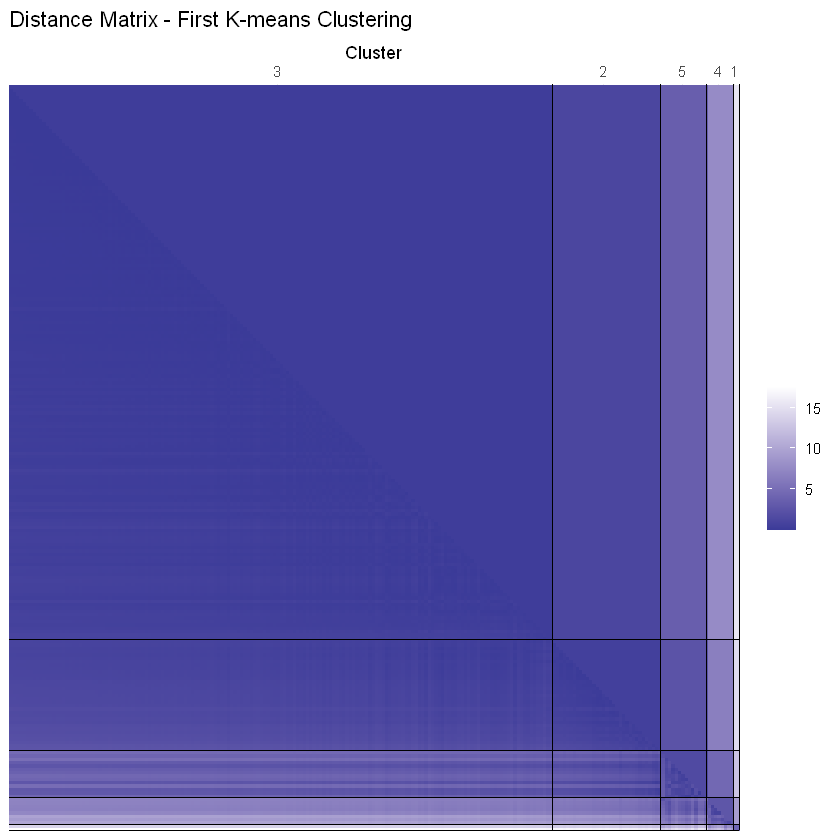

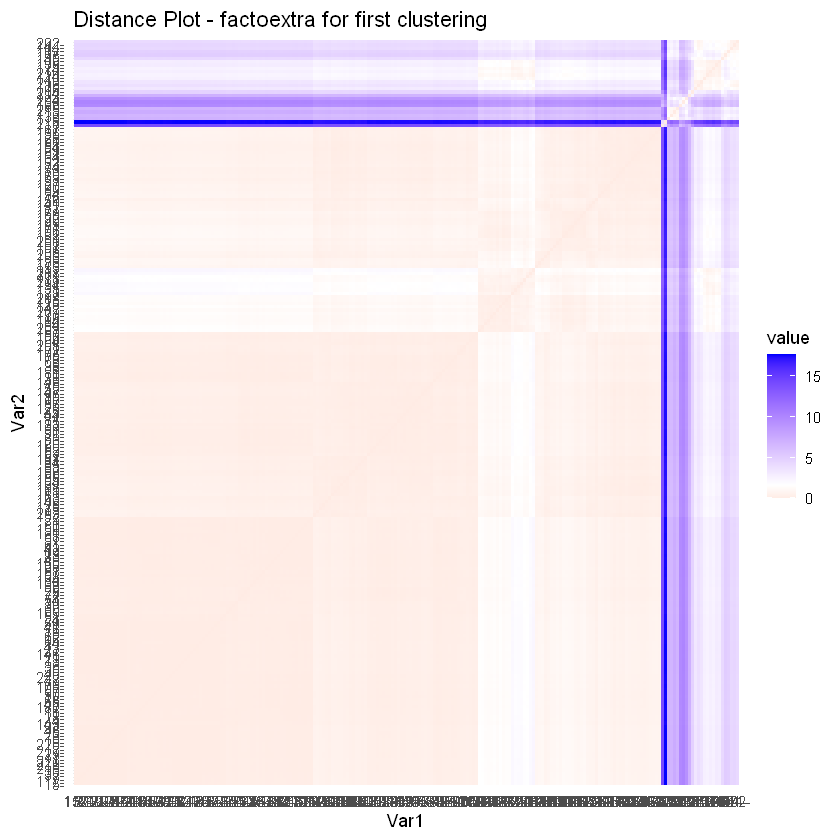

In [771]:
# K-means clustering using specific number of clusters
k_means_first_new <- kmeans(dataset_plus_census_scaled_first, centers=5, nstart = 10)

# Euclidean distance for the first dataset
d_first_new <- dist(dataset_plus_census_scaled_first)

# Create ggdissplot
diss_plot_first <- ggdissplot(d_first_new, labels = k_means_first_new$cluster) +
  ggtitle("Distance Matrix - First K-means Clustering") +
  theme_minimal()

# Create factoextra plot
fviz_plot_first <- fviz_dist(d_first_new) +
  ggtitle("Distance Plot - factoextra for first clustering") +
  theme_minimal()

# Display the plots
print(diss_plot_first)
print(fviz_plot_first)


Need 3 clusters because well defined.

In [777]:
# Save the plots
ggsave("distance_plot_first.png", plot = diss_plot_first, width = 10, height = 10)
ggsave("factoextra_plot_first.png", plot = fviz_plot_first, width = 10, height = 10)

### Determine suitable number of clusters

#### Average Silhouette Width

[1] 2


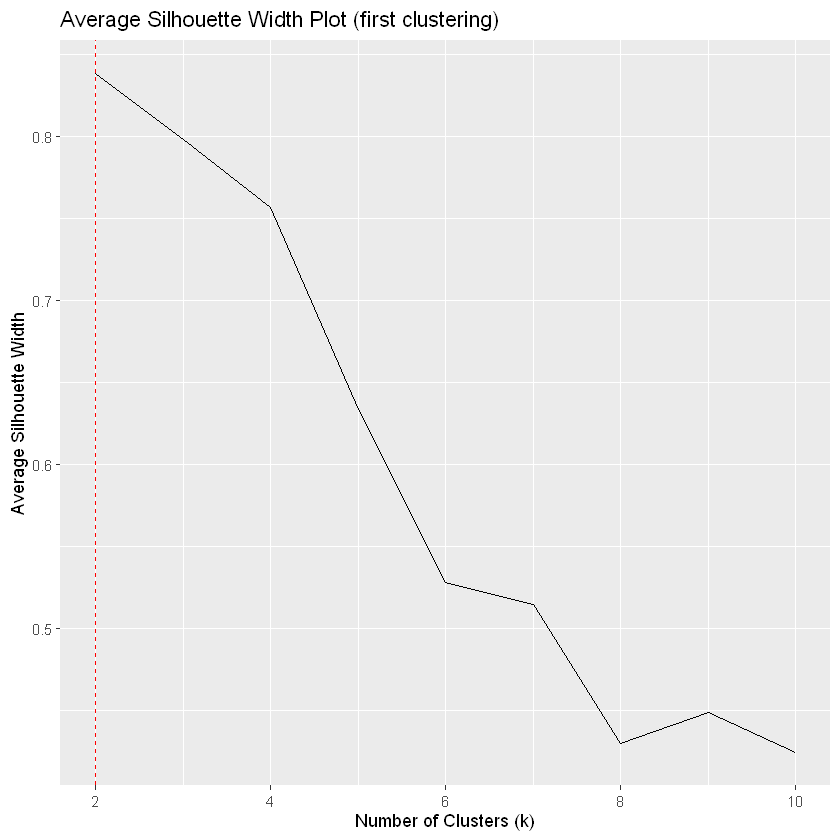

In [658]:
# range for number of clusters
ks_first <- 2:10

# distance
d_first <- dist(dataset_plus_census_scaled_first)

# Average Silhouette Width
ASW_first <- sapply(ks_first, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_first, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_first)
  mean(silhouette_info[, 3]) 
})

# best k
best_k_first <- ks_first[which.max(ASW_first)]
print(best_k_first)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_first, ASW_first), aes(x = ks_first, y = ASW_first)) + 
  geom_line() +
  geom_vline(xintercept = best_k_first, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (first clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")


  cluster size ave.sil.width
1       1   11          0.37
2       2  211          0.88
  cluster size ave.sil.width
1       1    8          0.43
2       2    2          0.54
3       3   21          0.37
4       4  191          0.82
  cluster size ave.sil.width
1       1   56          0.35
2       2   10          0.37
3       3  121          0.69
4       4   25          0.30
5       5    2          0.54
6       6    8          0.31
  cluster size ave.sil.width
1       1  102          0.63
2       2   26          0.14
3       3    9          0.32
4       4    8          0.16
5       5    8          0.28
6       6    2          0.54
7       7   18          0.39
8       8   49          0.38


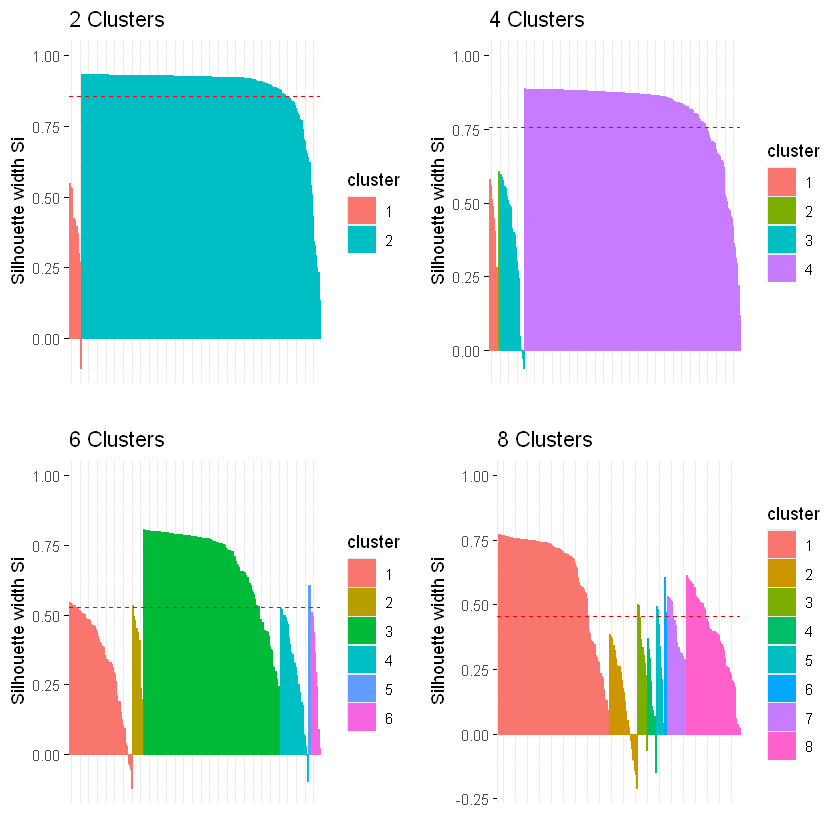

In [659]:
# K-means clustering (10 random restarts)
k_means_first_first <- kmeans(dataset_plus_census_scaled_first, centers=2, nstart = 10)
k_means_first_second <- kmeans(dataset_plus_census_scaled_first, centers=4, nstart = 10)
k_means_first_third <- kmeans(dataset_plus_census_scaled_first, centers=6, nstart = 10)
k_means_first_fourth <- kmeans(dataset_plus_census_scaled_first, centers=8, nstart = 10)

# Compute silhouette scores
sil_first_first <- silhouette(k_means_first_first$cluster, d_first)
sil_first_second <- silhouette(k_means_first_second$cluster, d_first)
sil_first_third <- silhouette(k_means_first_third$cluster, d_first)
sil_first_fourth <- silhouette(k_means_first_fourth$cluster, d_first)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_first_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_first_second) + ggtitle("4 Clusters")
p3 <- fviz_silhouette(sil_first_third) + ggtitle("6 Clusters")
p4 <- fviz_silhouette(sil_first_fourth) + ggtitle("8 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_first <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_first)

2 Clusters seems to be the optimal choice as it has one cluster with a very high silhouette width (0.88). Although the other cluster has a lower silhouette width (0.37), the simplicity of having fewer clusters often provides more meaningful insights without overcomplicating the interpretation.

The 4 Clusters option also shows promise, with two clusters having reasonably high silhouette widths (0.54 and 0.82), but the other two clusters have lower silhouette widths, reducing the overall quality of clustering. Also, the first and second clusters have very few datapoints.

#### Elbow Method: Within-Cluster Sum of Square

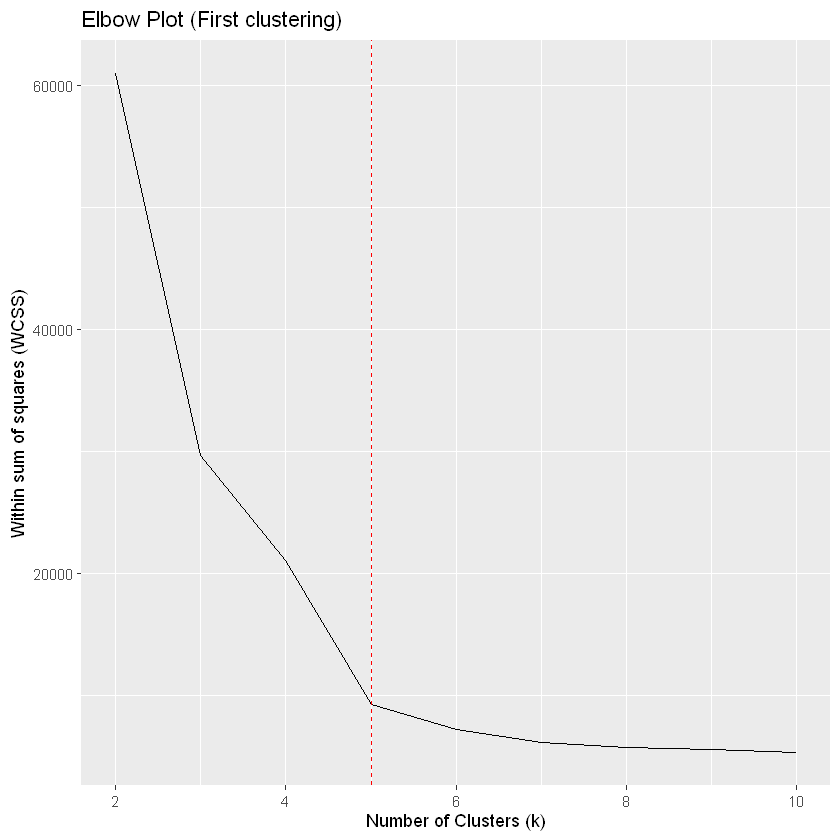

In [660]:
# Calculate within-cluster sum of squares for number of clusters
WCSS_first <- sapply(ks_first, FUN = function(k) {
  kmeans(dist(dataset_plus_census_scaled_first), centers = k, nstart = 10)$tot.withinss
})

# Plot 
ggplot(tibble(ks_first, WCSS_first), aes(ks_first, WCSS_first)) + 
  geom_line() +
  geom_vline(xintercept = 5, color = "red", linetype = 2) +
  ggtitle("Elbow Plot (First clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")


This indicates that after about 5 clusters, the within sum of squares does not seem to decrease significantly.

#### Gap Statistic

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_first, FUNcluster = kmeans, K.max = 20, nstart = 10)
B=100 simulated reference sets, k = 1..20; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.505528 5.898678 1.393151 0.02500495
 [2,] 4.099111 5.419595 1.320484 0.01879729
 [3,] 3.830568 5.215787 1.385218 0.01925256
 [4,] 3.625125 5.102945 1.477821 0.01907667
 [5,] 3.378416 5.007701 1.629285 0.01773935
 [6,] 3.193846 4.919023 1.725177 0.01649313
 [7,] 3.111963 4.839157 1.727194 0.01571926
 [8,] 3.043512 4.770855 1.727343 0.01552451
 [9,] 2.939648 4.714330 1.774681 0.01687517
[10,] 2.933884 4.666495 1.732611 0.01711719
[11,] 2.836550 4.623616 1.787067 0.01672755
[12,] 2.883565 4.588063 1.704498 0.01643977
[13,] 2.863939 4.554547 1.690607 0.01704881
[14,] 2.748701 4.523584 1.774883 0.01699435
[15,] 2.725631 4.493533 1.767902 0.01577295
[16,] 2.735736 4.465988 1.73025

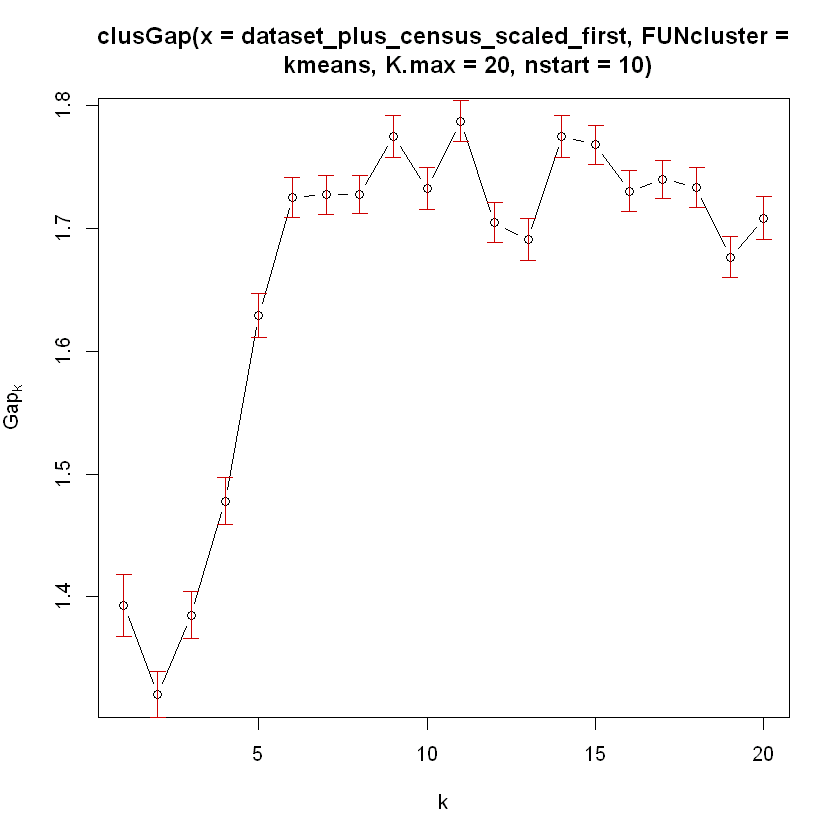

In [801]:
k_gap_first <- clusGap(dataset_plus_census_scaled_first, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 20)
k_gap_first

plot(k_gap_first)

Optimum number of clusters is 9 based on this assessment.

### Compare clusters (unsupervised)

In [662]:
# k-means clustering with different numbers of clusters
k_means_first_2 <- kmeans(dataset_plus_census_scaled_first, centers = 2)
k_means_first_3 <- kmeans(dataset_plus_census_scaled_first, centers = 3)
k_means_first_5 <- kmeans(dataset_plus_census_scaled_first, centers = 5)
k_means_first_6 <- kmeans(dataset_plus_census_scaled_first, centers = 6)

# Euclidean distance for first
d_first <- dist(dataset_plus_census_scaled_first)

# Compute clustering statistics for each clustering result
cluster_stats_first <- sapply(
  list(
    km_first_2 = k_means_first_2$cluster,
    km_first_3 = k_means_first_3$cluster,
    km_first_5 = k_means_first_5$cluster,
    km_first_6 = k_means_first_6$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_first, x)
)

# Extract the desired statistics
first_cluster_stats <- cluster_stats_first[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(first_cluster_stats)


                  km_first_2 km_first_3 km_first_5 km_first_6
within.cluster.ss 397.8061   215.1592   82.48649   71.37958  
avg.silwidth      0.8382507  0.798405   0.6334073  0.5284296 
pearsongamma      0.806838   0.771368   0.5600383  0.3993434 
dunn              0.04206167 0.03520247 0.02411328 0.01421393


Looking at the sum of squares, we see that the value starts to decrease not so sifnificantly after 5 clusters supporting the observation made on elbow method.  
Looking at the average silwidth values, we can see that it's max at 2 clusters.  
The pearson gamma values also indicate that we just need two clusters.
The dunn index also indicates that 2 clusters are needed. While increasing the number of clusters reduces the within-cluster sum of squares, it also leads to a decrease in the average silhouette width, Pearson gamma, and Dunn index, indicating lower clustering quality.

#### Inspect the clusters (Visualization)

Too few points to calculate an ellipse


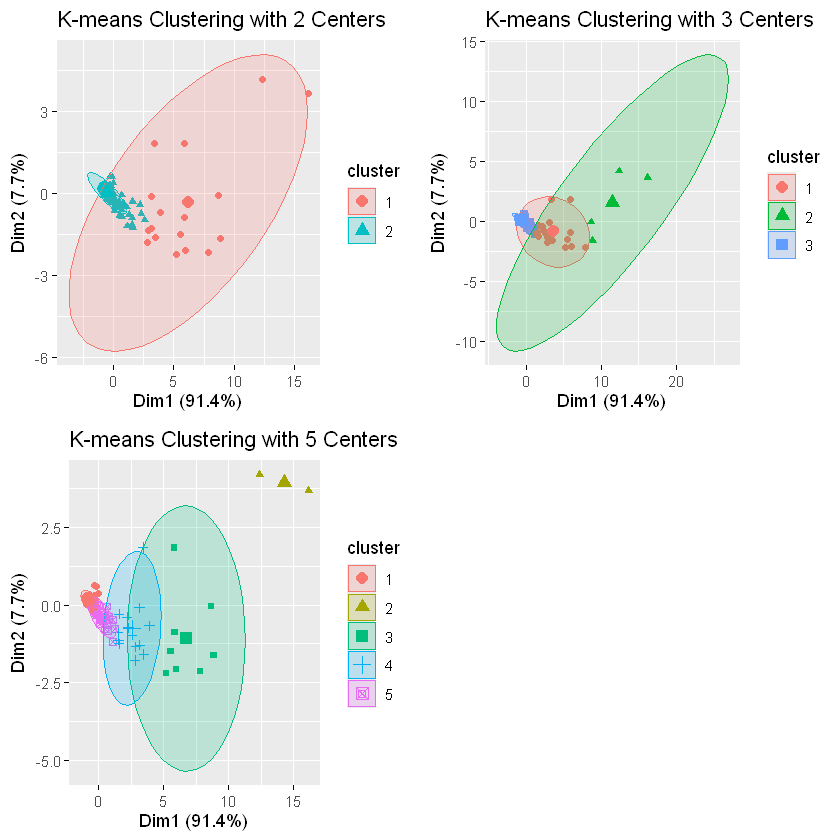

In [663]:
# K-means clustering with 2 clusters
kmeans_first_first <- kmeans(dataset_plus_census_scaled_first, centers = 2)
plot_kmeans_first_first <- fviz_cluster(kmeans_first_first, data = dataset_plus_census_scaled_first,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_first_second <- kmeans(dataset_plus_census_scaled_first, centers = 3)
plot_kmeans_first_second <- fviz_cluster(kmeans_first_second, data = dataset_plus_census_scaled_first,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 3 Centers")

# K-means clustering with 5 clusters
kmeans_first_third <- kmeans(dataset_plus_census_scaled_first, centers = 5)
plot_kmeans_first_third <- fviz_cluster(kmeans_first_third, data = dataset_plus_census_scaled_first,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 5 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_first <- ggarrange(plot_kmeans_first_first, plot_kmeans_first_second, plot_kmeans_first_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_first)

# Save the plot
ggsave("combined_plot_first.png", plot = combined_plot_first, width = 6, height = 3)


We need only 2 clusters.

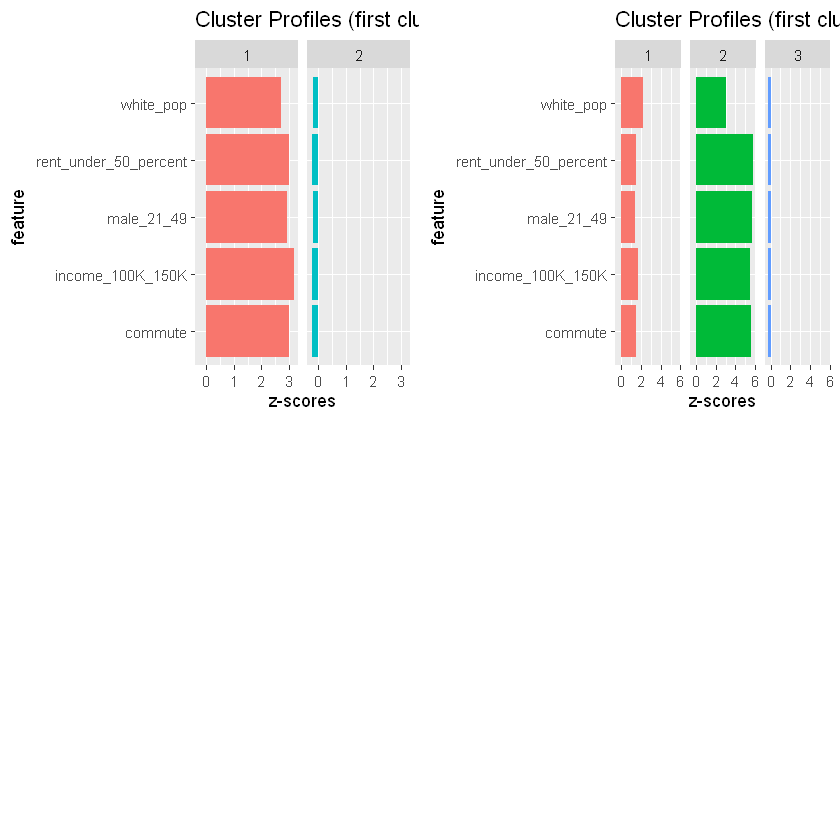

In [664]:
# Perform k-means clustering with 2 centers
k_means_first_2 <- kmeans(dataset_plus_census_scaled_first, centers = 2, nstart = 10)

cluster_profile_first_2 <- ggplot(pivot_longer(as_tibble(k_means_first_2$centers,  rownames = "cluster"), 
  cols = colnames(k_means_first_2$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (first clustering) with 2 clusters") + 
  guides(fill = "none")


# Perform k-means clustering with 3 centers
k_means_first_3 <- kmeans(dataset_plus_census_scaled_first, centers = 3, nstart = 10)

cluster_profile_first_3 <- ggplot(pivot_longer(as_tibble(k_means_first_3$centers,  rownames = "cluster"), 
  cols = colnames(k_means_first_3$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (first clustering) with 3 clusters") + 
  guides(fill = "none")


# Arrange the plots side by side in a 2x2 grid
combined_cluster_profile_first <- ggarrange(cluster_profile_first_2, cluster_profile_first_3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_cluster_profile_first)

# Save the plot
ggsave("combined_cluster_profile_first.png", plot = combined_cluster_profile_first, width = 5, height = 5)


We only need two clusters. Third clusters have similar distribution for all features. So the third cluster does not explain any siginificant amount of variance of the dataset.

In [643]:
k_means_first_2
k_means_first_3

K-means clustering with 2 clusters of sizes 205, 17

Cluster means:
   white_pop income_100K_150K rent_under_50_percent male_21_49    commute
1 -0.2234129       -0.2428966            -0.2308234  -0.221506 -0.2300256
2  2.6940965        2.9290478             2.7834583   2.671102  2.7738380

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 2 2 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 2 2 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 110.4237 287.3825
 (between_SS / total_SS =  64.0 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "be

K-means clustering with 3 clusters of sizes 198, 4, 20

Cluster means:
   white_pop income_100K_150K rent_under_50_percent male_21_49    commute
1 -0.2832547       -0.2812149            -0.2651004  -0.250856 -0.2626703
2  3.0595745        5.4310078             5.7490901   5.656383  5.5858228
3  2.1923068        1.6978259             1.4746759   1.352198  1.4832710

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 3 3 1 1 2 3 1 1 1 1 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 3 3 1 1 1 3 3 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 3 3 3 1 3 1 1 3 1 3 1 1 1 1 1 3 1 1 3 3 3 2 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 60.58115 64.87027 89.70776
 (between_SS / total_SS =  80.5 %)

Available components:



 The ratio of between_SS to total_SS is about 57%, suggesting that the clustering structure explains a significant portion of the variability in the data.  
Given that the first cluster has distinctly different characteristics compared to the second and that we see a clear separation in terms of average feature values, it is reasonable to conclude that two clusters are sufficient to define the dataset.

### Heat map

In [676]:
# load the dataset
dataset_plus_census_heatmap_first <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>% filter(state == "TX")

# Filter out the major counties (DFW, Austin, San Antonio and Houston)
counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

# filter the dataset
dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>%
  filter(!(county_name %in% counties_to_exclude))

# select the features
dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>%  
  select(county_name, confirmed_cases, deaths, total_pop, white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, amerindian_pop, other_race_pop, income_less_50K, 
         income_50K_100K, income_100K_150K, income_150K_more)

In [678]:
length(unique(dataset_plus_census_heatmap_first$county_name))

[1] 222

Altogether there are 32 counties that are part of these 4 major cities. Previously we had 254 counties and now we have 222 counties. 

In [679]:
# per 1000
dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

# extract the polygan data
counties_polygon <- as_tibble(map_data("county"))
counties_polygon_TX <- counties_polygon %>% dplyr::filter(region == "texas") %>% 
  rename(c(county = subregion)) 

# remove "County" from the names and convert thme to lowercase
counties_to_exclude <- tolower(gsub(" County", "", counties_to_exclude))

# filter the dataset to match with our dataset for joining purpose
counties_polygon_TX <- counties_polygon_TX %>%
  filter(!(county %in% counties_to_exclude))

In [680]:
length(unique(counties_polygon_TX$county))

[1] 222

We are good to preceed.

In [681]:
# remove County from the names and convert them to lowercase
dataset_plus_census_heatmap_first <- dataset_plus_census_heatmap_first %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_plus_census_heatmap_first)

Joining with `by = join_by(county)`


In [682]:
head(counties_polygon_TX)

long,lat,group,order,region,county,county_name,confirmed_cases,deaths,total_pop,⋯,hispanic_pop,amerindian_pop,other_race_pop,income_less_50K,income_50K_100K,income_100K_150K,income_150K_more,cases_per_1000,deaths_per_1000,death_per_case
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
-95.75271,31.53560,2492,74520,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.76989,31.55852,2492,74521,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.76416,31.58143,2492,74522,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.72979,31.58143,2492,74523,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.74698,31.61008,2492,74524,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291
-95.72405,31.63873,2492,74525,texas,anderson,Anderson County,5575,75,57747,⋯,9981,160,11,9357,4937,1499,774,96.54181,1.298769,0.01345291


In [683]:
# Scaling
dataset_plus_census_heatmap_first_scaled <- dataset_plus_census_heatmap_first %>% 
  select(white_pop, black_pop, asian_pop, hispanic_pop, amerindian_pop, amerindian_pop, other_race_pop, income_less_50K, income_50K_100K, income_100K_150K, income_150K_more) %>% 
  scale() %>% as_tibble()

# k means setting
km_heatmap_first <- kmeans(dataset_plus_census_heatmap_first_scaled, centers = 2, nstart = 10)

# Add the cluster labels to the dataset
dataset_plus_census_clust_heatmap_first <- dataset_plus_census_heatmap_first %>% 
    add_column(cluster = factor(km_heatmap_first$cluster))

In [684]:
# Database join
counties_polygon_TX_clust <- right_join(counties_polygon_TX, dataset_plus_census_clust_heatmap_first, 
                                        join_by(county))

In [685]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_clust$county))

[1] 222

 [1] "bell"      "brazos"    "cameron"   "ector"     "el paso"   "grayson"  
 [7] "hidalgo"   "jefferson" "lubbock"   "mclennan"  "midland"   "nueces"   
[13] "randall"   "smith"     "taylor"    "wichita"  


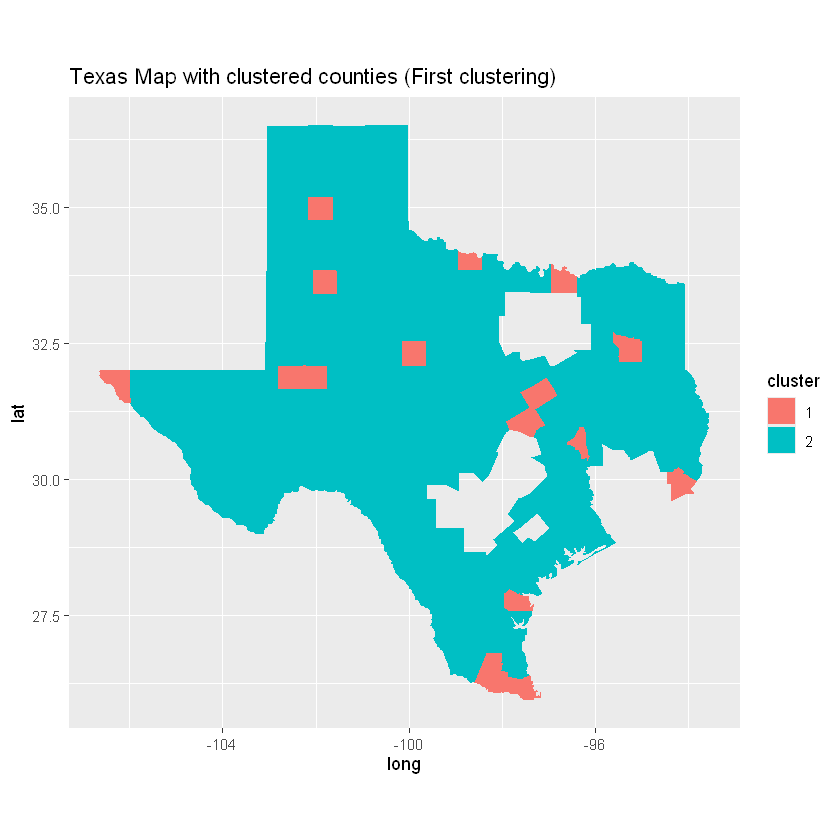

In [687]:
# heat map
ggplot(counties_polygon_TX_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (First clustering)")

# Filter for counties in cluster 1
counties_cluster_1 <- counties_polygon_TX_clust %>%
  filter(cluster == 1)

# Print the counties in cluster 1
print(unique(counties_cluster_1$county))

The above heat map shows 2 clusters based on the features selected for the dataset. Also we can see the counties that belong to cluster 1 based on the selected features.  

In [697]:
dataset_plus_census_clust_heatmap_first %>% group_by(cluster) %>% summarize(
  avg_cases_per_1000 = mean(cases_per_1000), 
  avg_deaths_per_1000 = mean(deaths_per_1000))

cluster,avg_cases_per_1000,avg_deaths_per_1000
<fct>,<dbl>,<dbl>
1,88.22725,1.657642
2,78.07511,2.009892


We can see that all the counties from cluster 1 have average cases of 88.22 per 1000 confirmed cases, and 1.65 per 1000 death cases. This is based on the selected features.

## K-means (Euclidean distance) for variables related to hispanic race, making 50-100K, female aged 21-49, and worked from home

In [778]:
# Prepare the dataset
dataset_plus_census_second <- dataset_plus_census %>% 
  select(hispanic_pop, income_50K_100K, female_21_49, worked_at_home) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_scaled_second <- scale(dataset_plus_census_second)

In [779]:
head(dataset_plus_census_scaled_second)

hispanic_pop,income_50K_100K,female_21_49,worked_at_home
-0.2177805,-0.4293063,-0.3491287,-0.3892081
-0.2479489,-0.4678877,-0.3982314,-0.3965838
-0.2294297,-0.4543727,-0.3760021,-0.3858555
-0.2181961,-0.4308079,-0.3695316,-0.3610461
-0.2177546,-0.3700479,-0.3344657,-0.3603756
-0.2339102,-0.4430524,-0.3739670,-0.3757976


In [780]:
dataset_plus_census_scaled_second_summary <- summary(dataset_plus_census_scaled_second)

dataset_plus_census_scaled_second_summary

  hispanic_pop     income_50K_100K     female_21_49      worked_at_home    
 Min.   :-0.2510   Min.   :-0.48025   Min.   :-0.40366   Min.   :-0.40128  
 1st Qu.:-0.2321   1st Qu.:-0.42067   1st Qu.:-0.35719   1st Qu.:-0.35535  
 Median :-0.2031   Median :-0.31755   Median :-0.29011   Median :-0.27388  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.00000  
 3rd Qu.:-0.1235   3rd Qu.:-0.06348   3rd Qu.:-0.09495   3rd Qu.:-0.05596  
 Max.   : 9.7590   Max.   : 8.07375   Max.   : 8.17512   Max.   : 9.67399  

Mean is 0 for all columns. Min and max is similar to all columns. So scaling is good.

In [781]:
write.csv(dataset_plus_census_scaled_second_summary, "dataset_plus_census_scaled_second_summary.csv", row.names = FALSE)

### Clustering Tendency (Hopkins Statistic)

In [782]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_second <- hopkins(dataset_plus_census_scaled_second)
hopkins_stat_second

[1] 0.9999962

This shows that there is a strong clustering tendency.

### Average Silhouette Width

Warning message:
"did not converge in 10 iterations"


[1] 2


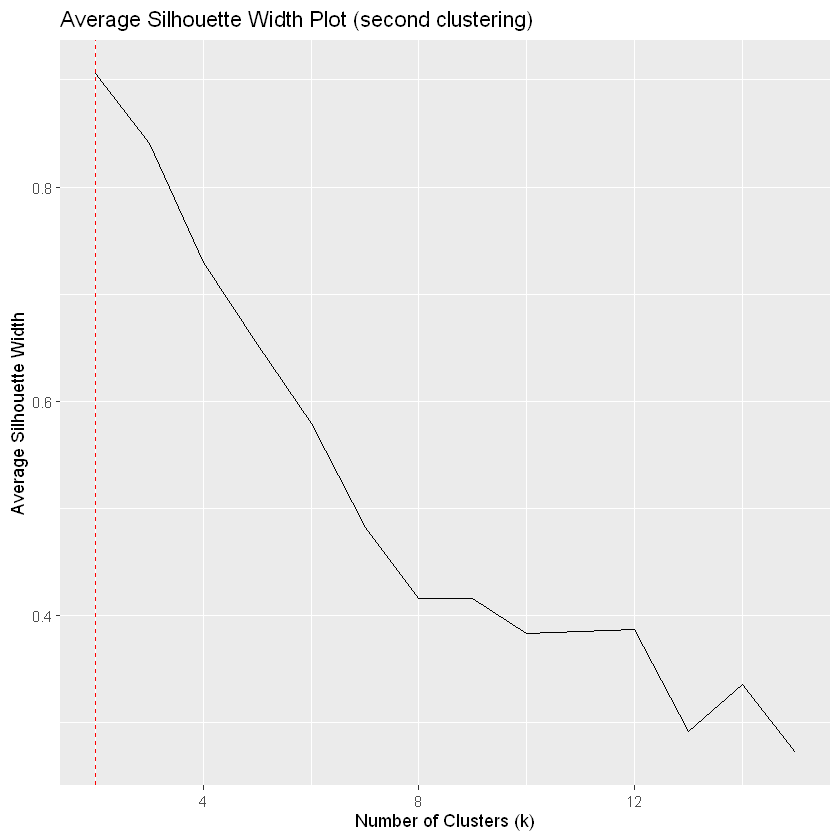

In [783]:
# range for number of clusters
ks_second <- 2:15

# distance
d_second <- dist(dataset_plus_census_scaled_second)

# Average Silhouette Width
ASW_second <- sapply(ks_second, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_second, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_second)
  mean(silhouette_info[, 3]) 
})

# best k
best_k_second <- ks_second[which.max(ASW_second)]
print(best_k_second)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_second, ASW_second), aes(x = ks_second, y = ASW_second)) + 
  geom_line() +
  geom_vline(xintercept = best_k_second, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (second clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")


  cluster size ave.sil.width
1       1  217          0.92
2       2    5          0.17
  cluster size ave.sil.width
1       1    2          0.79
2       2  204          0.88
3       3   16          0.32
  cluster size ave.sil.width
1       1   35          0.32
2       2  168          0.75
3       3    5          0.23
4       4    2          0.76
5       5   12          0.37


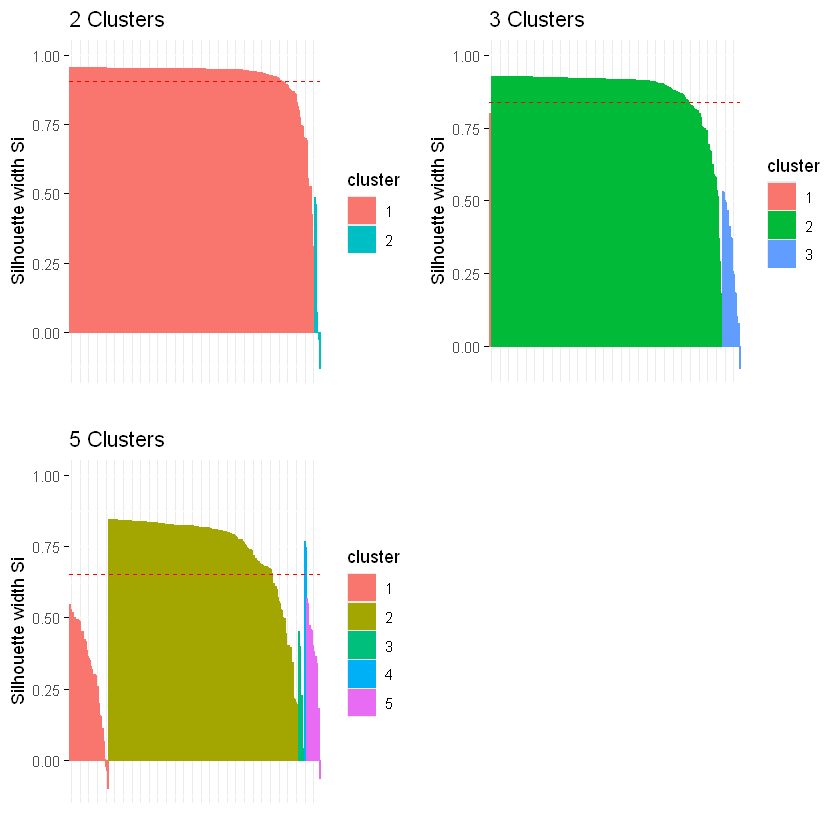

In [784]:
# K-means clustering (10 random restarts)
k_means_second_first <- kmeans(dataset_plus_census_scaled_second, centers=2, nstart = 10)
k_means_second_second <- kmeans(dataset_plus_census_scaled_second, centers=3, nstart = 10)
k_means_second_third <- kmeans(dataset_plus_census_scaled_second, centers=5, nstart = 10)

# Compute silhouette scores
sil_second_first <- silhouette(k_means_second_first$cluster, d_second)
sil_second_second <- silhouette(k_means_second_second$cluster, d_second)
sil_second_third <- silhouette(k_means_second_third$cluster, d_second)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_second_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_second_second) + ggtitle("3 Clusters")
p3 <- fviz_silhouette(sil_second_third) + ggtitle("5 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_second <- ggarrange(p1, p2, p3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_second)


Considering both the silhouette width and the distribution of cluster sizes, the clustering with 2 clusters seems to be the most appropriate choice. Cluster 1 has a very high silhouette width (0.92), indicating well-separated clusters. While Cluster 2 is small (5), the overall simplicity and high silhouette width for the main cluster make this a reasonable choice.

### Elbow Method: Within-Cluster Sum of Square

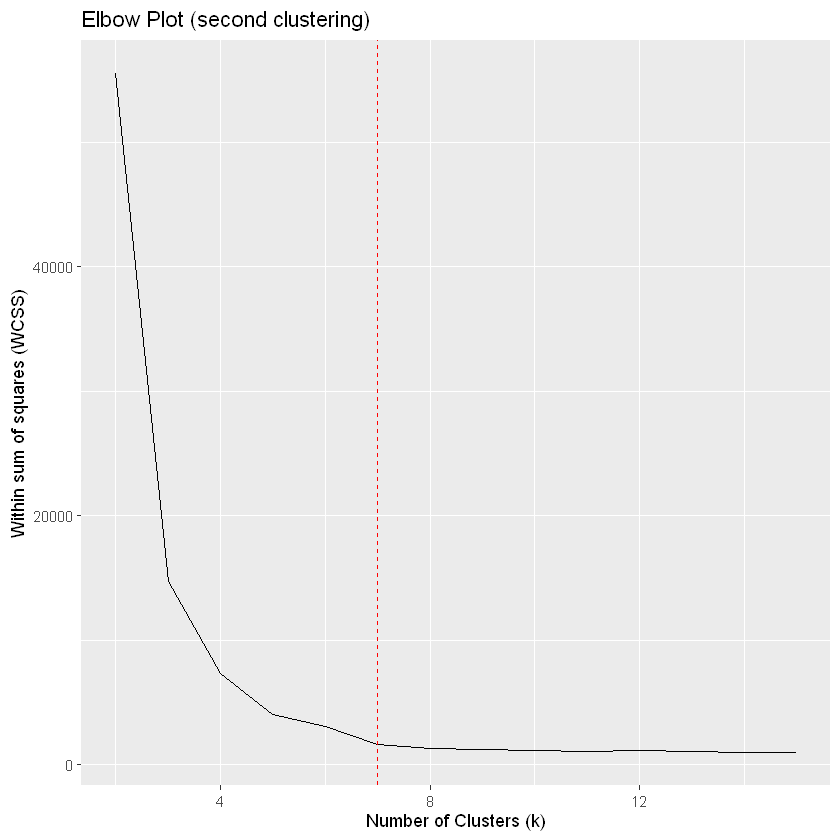

In [785]:
# Use the same range of K
# Calculate within-cluster sum of squares for number of clusters
WCSS_second <- sapply(ks_second, FUN = function(k) {
  kmeans(d_second <- dist(dataset_plus_census_scaled_second), centers = k, nstart = 10)$tot.withinss
})

# Plot 
ggplot(tibble(ks_second, WCSS_second), aes(ks_second, WCSS_second)) + 
  geom_line() +
  geom_vline(xintercept = 7, color = "red", linetype = 2) +
  ggtitle("Elbow Plot (second clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")


Shows 7 clusters is the optimum number of clusters.

### Gap Statistic

Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"


Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_second, FUNcluster = kmeans, K.max = 20, nstart = 10)
B=100 simulated reference sets, k = 1..20; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.204376 5.891265 1.686889 0.02526238
 [2,] 3.892098 5.367561 1.475463 0.02197035
 [3,] 3.470144 5.134454 1.664310 0.01958806
 [4,] 3.225703 5.006047 1.780344 0.01797222
 [5,] 3.018426 4.922710 1.904284 0.01641111
 [6,] 2.896687 4.854945 1.958258 0.01611928
 [7,] 2.768341 4.792376 2.024036 0.01597732
 [8,] 2.720275 4.735537 2.015262 0.01575331
 [9,] 2.662677 4.682100 2.019423 0.01513682
[10,] 2.564283 4.634323 2.070040 0.01515397
[11,] 2.516930 4.593219 2.076289 0.01637185
[12,] 2.487921 4.556606 2.068685 0.01611896
[13,] 2.458731 4.523099 2.064368 0.01653585
[14,] 2.440856 4.492978 2.052122 0.01614395
[15,] 2.401212 4.464483 2.063271 0.01655585
[16,] 2.400035 4.436530 2.0364

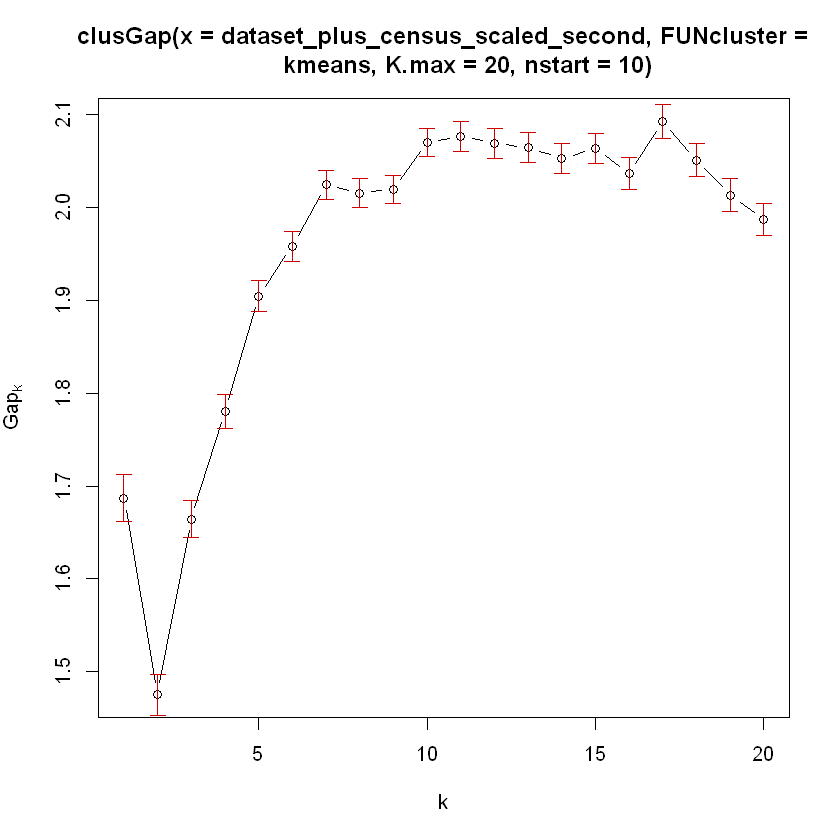

In [800]:
k_gap_second <- clusGap(dataset_plus_census_scaled_second, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 20)
k_gap_second

plot(k_gap_second)

Based on the gap statistic, we see that 11 clusters could be enough for the clusters.

### Clustering Tendency (Hopkins Statistic)

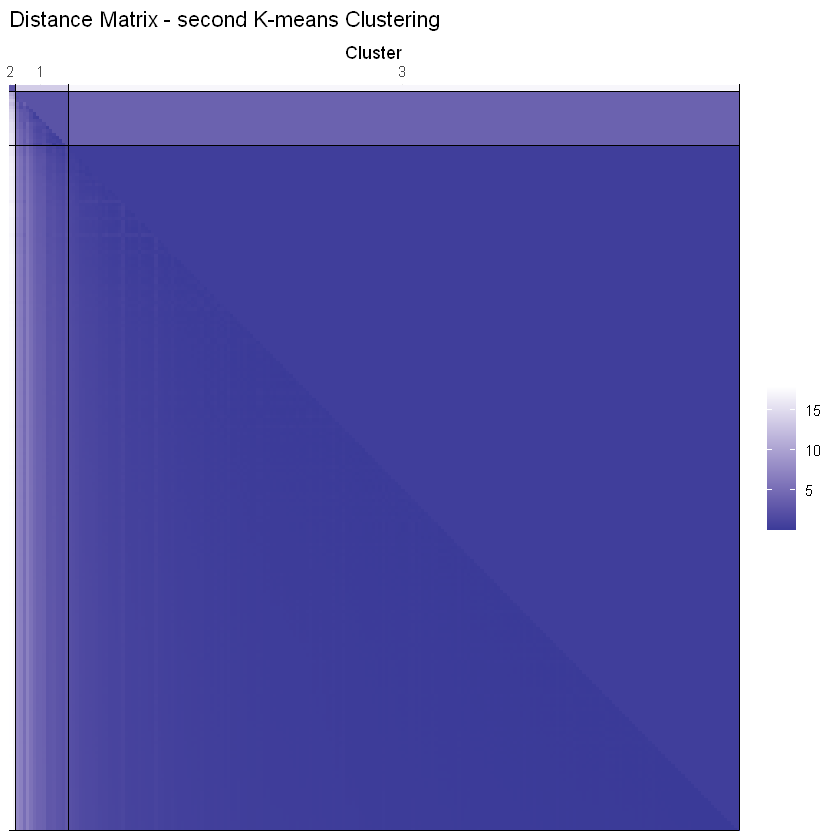

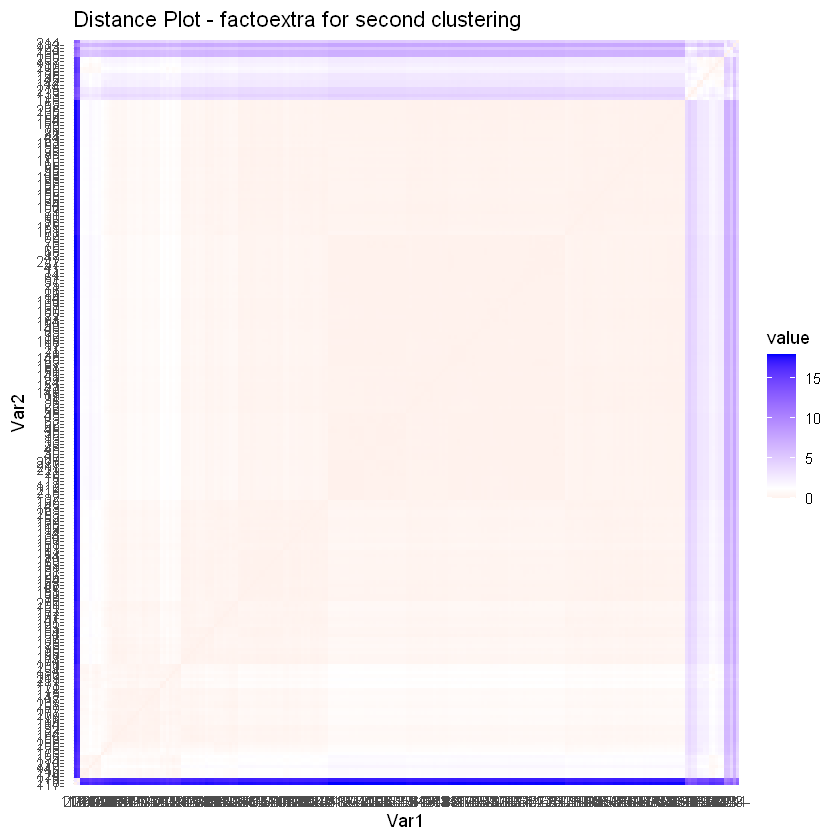

In [787]:
# K-means clustering using specific number of clusters
k_means_second_new <- kmeans(dataset_plus_census_scaled_second, centers = 3, nstart = 10)

# Distance for second dataset
d_second_new <- dist(dataset_plus_census_scaled_second)

# Create ggdissplot
diss_plot_second <- ggdissplot(d_second_new, labels = k_means_second_new$cluster) +
  ggtitle("Distance Matrix - second K-means Clustering") +
  theme_minimal()

# Create factoextra plot
fviz_plot_second <- fviz_dist(d_second_new) +
  ggtitle("Distance Plot - factoextra for second clustering") +
  theme_minimal()

# Display the plots
diss_plot_second
fviz_plot_second


Looks like we just need 3 clusters for the dataset.

In [788]:
# Save the plots
ggsave("distance_plot_second.png", plot = diss_plot_second, width = 10, height = 10)
ggsave("factoextra_plot_second.png", plot = fviz_plot_second, width = 10, height = 10)

### Compare clusterings (unsupervised)

In [709]:
# K-means clustering with different numbers of clusters
k_means_second_first <- kmeans(dataset_plus_census_scaled_second, centers = 2)
k_means_second_second <- kmeans(dataset_plus_census_scaled_second, centers = 3)
k_means_second_third <- kmeans(dataset_plus_census_scaled_second, centers = 4)
k_means_second_fourth <- kmeans(dataset_plus_census_scaled_second, centers = 6)

# Compute clustering statistics for each clustering result
cluster_stats <- sapply(
  list(
    km_first = k_means_second_first$cluster,
    km_second = k_means_second_second$cluster,
    km_third = k_means_second_third$cluster,
    km_fourth = k_means_second_fourth$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_second, x)
)

# Extract the desired statistics
second_cluster_stats <- cluster_stats[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(second_cluster_stats)


                  km_first  km_second  km_third   km_fourth 
within.cluster.ss 336.9456  103.8761   64.20614   38.06195  
avg.silwidth      0.9055904 0.8404076  0.729722   0.579127  
pearsongamma      0.8086453 0.7104225  0.5720946  0.4022496 
dunn              0.1275271 0.07974147 0.03998538 0.01211304


Looking at the sum of squares, we see that the value starts to decrease not so sifnificantly after 4 clusters. 
Looking at the average silwidth values, we can see that it's max at two clusters.
The pearson gamma values also indicate that we just need two clusters. 
The dunn index also indicates that we need 2 clusters for this dataset since it has the highest value for 2 clusters. The value does not improve (does not decrease) with  more clusters added. 
Overall, these values indicate that adding more clusters might lead to more compact clusters but less defined and well-separated clusters. Therefore, 2 clusters could offer the most robust clustering for the dataset.

#### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse


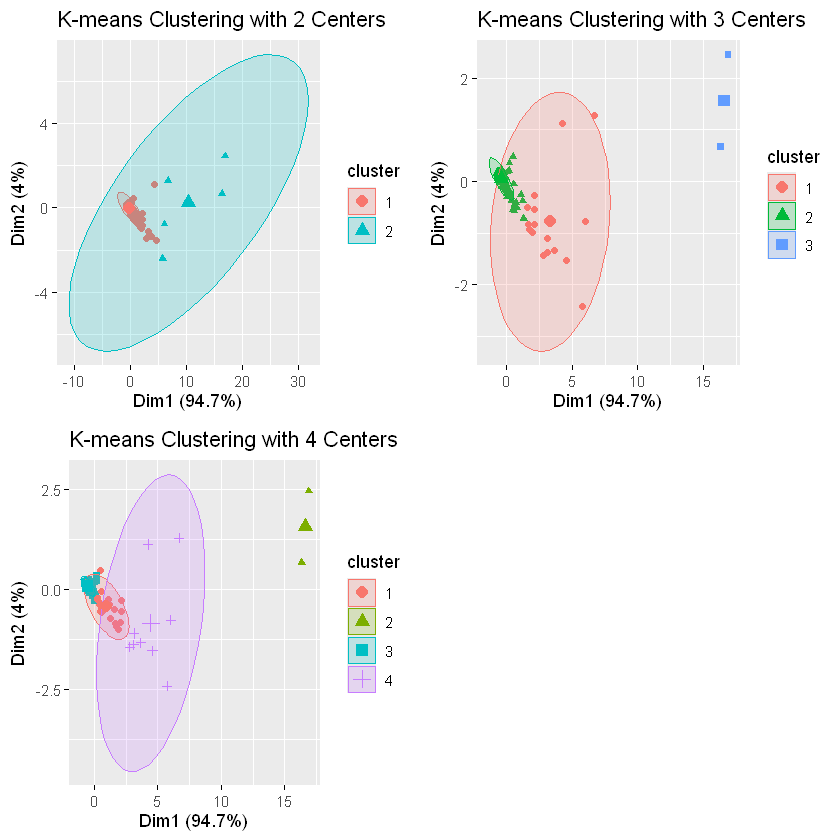

In [710]:
# K-means clustering with 2 clusters
kmeans_second_first <- kmeans(dataset_plus_census_scaled_second, centers = 2)
plot_kmeans_second_first <- fviz_cluster(kmeans_second_first, data = dataset_plus_census_scaled_second,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_second_second <- kmeans(dataset_plus_census_scaled_second, centers = 3)
plot_kmeans_second_second <- fviz_cluster(kmeans_second_second, data = dataset_plus_census_scaled_second,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 3 Centers")

# K-means clustering with 4 clusters
kmeans_second_third <- kmeans(dataset_plus_census_scaled_second, centers = 4)
plot_kmeans_second_third <- fviz_cluster(kmeans_second_third, data = dataset_plus_census_scaled_second,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 4 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_second <- ggarrange(plot_kmeans_second_first, plot_kmeans_second_second, plot_kmeans_second_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_second)

# Save the plot
ggsave("combined_plot_second.png", plot = combined_plot_second, width = 6, height = 3)


We can see that the datapoints on cluster 3 are just outliers. So we are good with only 2 clusters for the dataset.

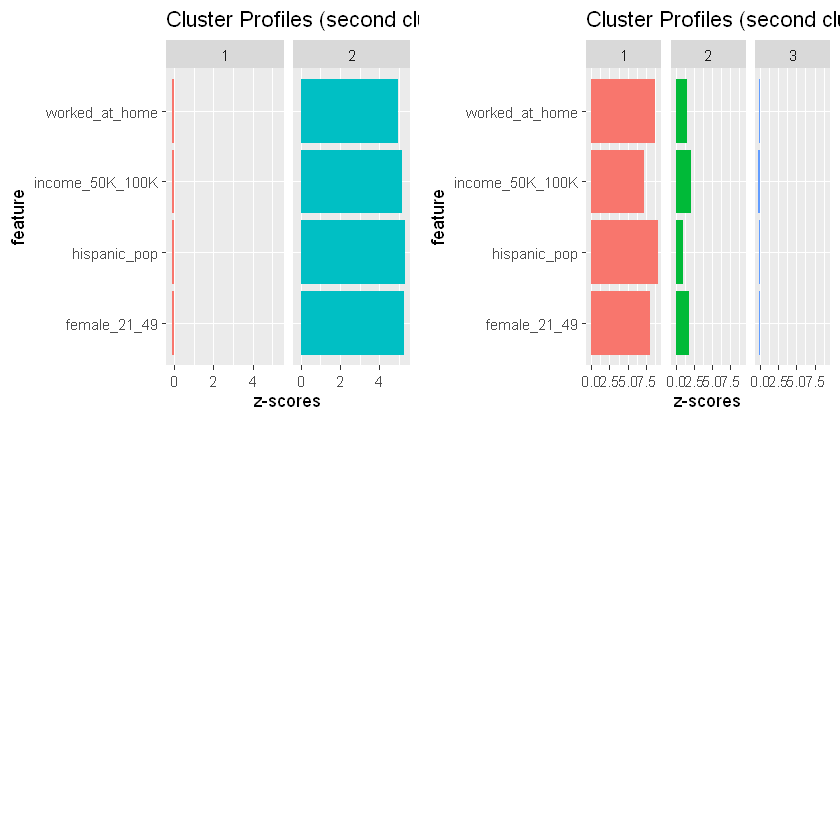

In [712]:
# Perform k-means clustering with 2 centers
k_means_second_2 <- kmeans(dataset_plus_census_scaled_second, centers = 2, nstart = 10)

cluster_profile_second_2 <- ggplot(pivot_longer(as_tibble(k_means_second_2$centers, rownames = "cluster"), 
  cols = colnames(k_means_second_2$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (second clustering) with 2 clusters") + 
  guides(fill = "none")


# Perform k-means clustering with 3 centers
k_means_second_3 <- kmeans(dataset_plus_census_scaled_second, centers = 3, nstart = 10)

cluster_profile_second_3 <- ggplot(pivot_longer(as_tibble(k_means_second_3$centers, rownames = "cluster"), 
  cols = colnames(k_means_second_3$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (second clustering) with 3 clusters") + 
  guides(fill = "none")


# Arrange the plots side by side in a 2x2 grid
combined_cluster_profile_second <- ggarrange(cluster_profile_second_2, cluster_profile_second_3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_cluster_profile_second)

# Save the plot
ggsave("combined_cluster_profile_second.png", plot = combined_cluster_profile_second, width = 5, height = 5)

When 3 clusters were used, the third cluster had all the distributions for all features nearly similar which is not a good to provide variability details on the dataset. Using only 2 clusters, majority of the variation of the dataset was properly defined between the clusters. This indicates that we might need only 2 clusters for the dataset.

In [713]:
k_means_second_2

K-means clustering with 2 clusters of sizes 217, 5

Cluster means:
  hispanic_pop income_50K_100K female_21_49 worked_at_home
1   -0.1222191      -0.1186235   -0.1214957     -0.1140559
2    5.3043074       5.1482606    5.2729141      4.9500279

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 184.7281 152.2175
 (between_SS / total_SS =  61.9 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifa

The ratio of between_SS to total_SS is about 61.9%, suggesting that the clustering structure explains a significant portion of the variability in the data.
Given that the first cluster has distinctly different characteristics compared to the second and that we see a clear separation in terms of average feature values, it is reasonable to conclude that two clusters are sufficient to define the dataset.

### Heat map

In [723]:
# Load the dataset
dataset_second_heatmap <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_second_heatmap <- dataset_second_heatmap %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_second_heatmap <- dataset_second_heatmap %>% filter(state == "TX")

# Filter the dataset
dataset_second_heatmap <- dataset_second_heatmap %>%
  filter(!(county_name %in% counties_to_exclude))

# Select the features
dataset_second_heatmap <- dataset_second_heatmap %>%  
  select(county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K, female_21_49, worked_at_home)

# Per 1000
dataset_second_heatmap <- dataset_second_heatmap %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)


In [724]:
# remove County from the names and convert them to lowercase
dataset_second_heatmap <- dataset_second_heatmap %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_second_heatmap)

Joining with `by = join_by(county, county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K,
cases_per_1000, deaths_per_1000, death_per_case, female_21_49, worked_at_home)`


In [725]:
# Scaling
dataset_second_heatmap_scaled <- dataset_second_heatmap %>% 
  select(hispanic_pop, income_50K_100K, female_21_49, worked_at_home) %>% 
  scale() %>% as_tibble()

# k means setting
km_second_heatmap <- kmeans(dataset_second_heatmap_scaled, centers = 2, nstart = 10)

In [726]:
# Add the cluster labels to the dataset
dataset_plus_census_second_clust_heatmap <- dataset_second_heatmap %>% 
    add_column(cluster = factor(km_second_heatmap$cluster))

In [727]:
# Database join
counties_polygon_TX_second_clust_second <- right_join(counties_polygon_TX, dataset_plus_census_second_clust_heatmap, 
                                        join_by(county))

In [728]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_second_clust$county))

[1] 222

[1] "bell"    "cameron" "el paso" "hidalgo" "nueces" 


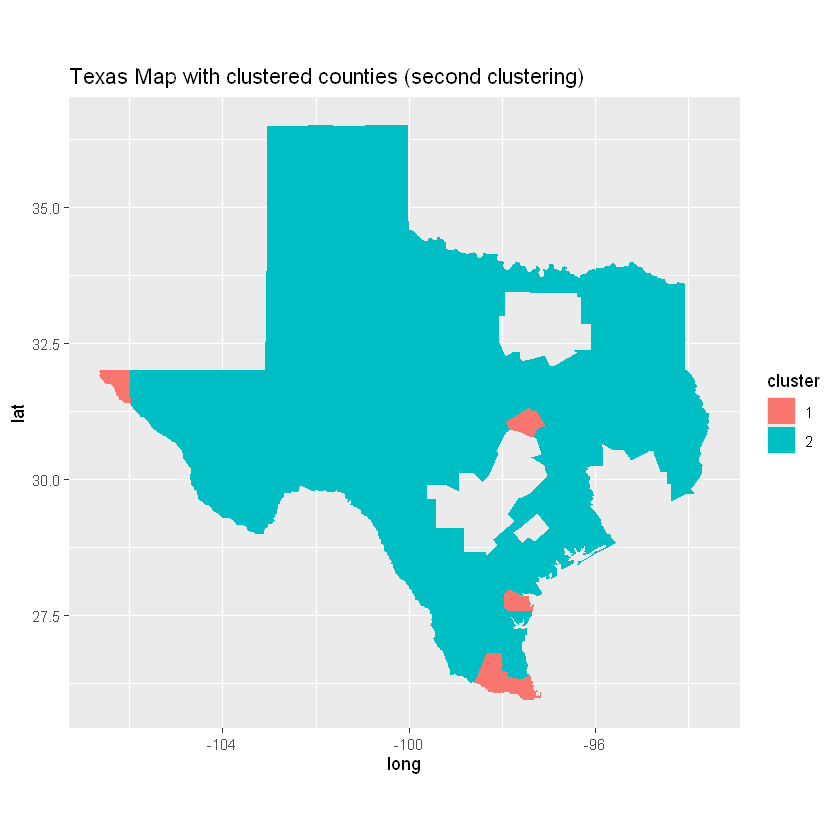

In [729]:
# heat map
ggplot(counties_polygon_TX_second_clust, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (second clustering)")

# Filter for counties in cluster 1
counties_cluster_1 <- counties_polygon_TX_second_clust %>%
  filter(cluster == 1)

# Print the counties in cluster 1
print(unique(counties_cluster_1$county))

The above heat map shows 2 clusters based on the features selected for the dataset. Also we can see the counties that belong to cluster 1 based on the selected features.  

In [731]:
dataset_plus_census_second_clust_heatmap %>% group_by(cluster) %>% summarize(
  avg_cases_per_1000 = mean(cases_per_1000), 
  avg_deaths_per_1000 = mean(deaths_per_1000))

cluster,avg_cases_per_1000,avg_deaths_per_1000
<fct>,<dbl>,<dbl>
1,98.03851,2.363770
2,78.63196,1.981056


We can see that all the counties from cluster 1 have average cases of 98 per 1000 confirmed cases, and 2.63 per 1000 death cases. This is based on the selected features.

## K-means (Euclidean distance) for variables related to males aged 50 above, income 150k more, spending less than 50% on rent, and commuted to work

In [790]:
# Prepare the dataset
dataset_plus_census_third <- dataset_plus_census %>% 
  select(income_100K_150K, rent_under_50_percent, male_50_above, commute) %>% 
  scale() %>% as_tibble()

# Scale the columns for K-means
dataset_plus_census_scaled_third <- scale(dataset_plus_census_third)

In [791]:
head(dataset_plus_census_scaled_third)

income_100K_150K,rent_under_50_percent,male_50_above,commute
-0.4401619,-0.3606743,-0.4551314,-0.3828995
-0.4769018,-0.4018415,-0.5015824,-0.4307855
-0.4641491,-0.3943454,-0.4851651,-0.4113773
-0.4189074,-0.3845144,-0.4686699,-0.3969089
-0.4043329,-0.3607972,-0.3895398,-0.3534498
-0.4447164,-0.3940996,-0.4806523,-0.4025235


In [792]:
dataset_plus_census_scaled_third_summary <- summary(dataset_plus_census_scaled_third)

dataset_plus_census_scaled_third_summary

 income_100K_150K   rent_under_50_percent male_50_above          commute       
 Min.   :-0.49239   Min.   :-0.4068       Min.   :-0.524613   Min.   :-0.4412  
 1st Qu.:-0.43887   1st Qu.:-0.3720       1st Qu.:-0.440329   1st Qu.:-0.3834  
 Median :-0.34345   Median :-0.3069       Median :-0.306636   Median :-0.3081  
 Mean   : 0.00000   Mean   : 0.0000       Mean   : 0.000000   Mean   : 0.0000  
 3rd Qu.:-0.07254   3rd Qu.:-0.1408       3rd Qu.:-0.000192   3rd Qu.:-0.0800  
 Max.   : 7.37936   Max.   : 8.5854       Max.   : 7.969696   Max.   : 8.2967  

In [793]:
write.csv(dataset_plus_census_scaled_third_summary, "dataset_plus_census_scaled_third_summary.csv", row.names = FALSE)

### Clustering Tendency (Hopkins Statistic)

In [794]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_third <- hopkins(dataset_plus_census_scaled_third)
hopkins_stat_third

[1] 0.9999943

### Factoextra & Distance/Dissimilarity plots

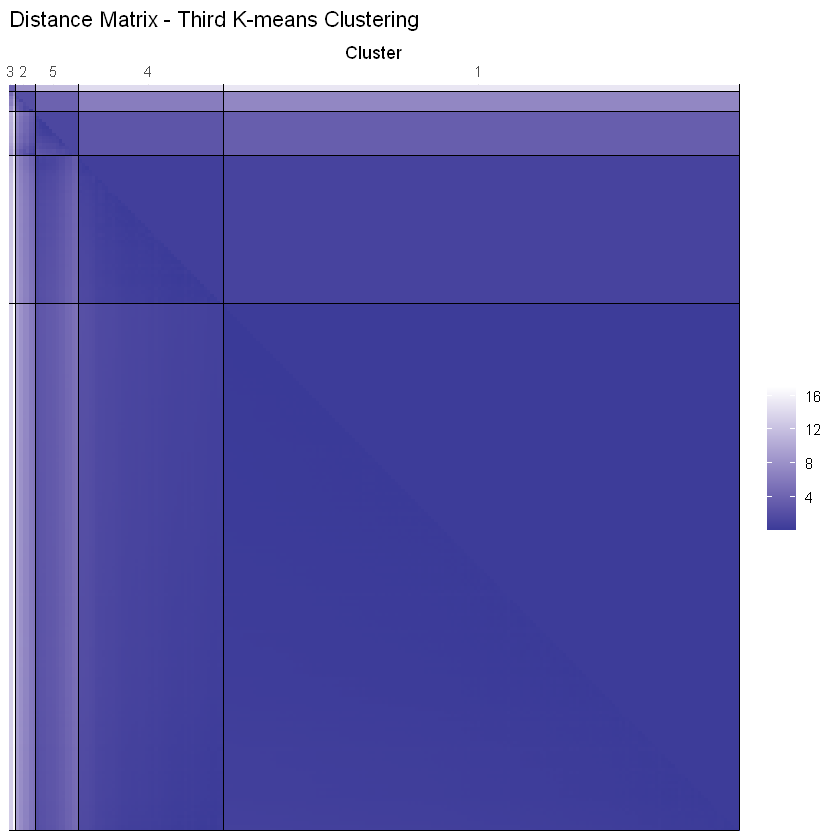

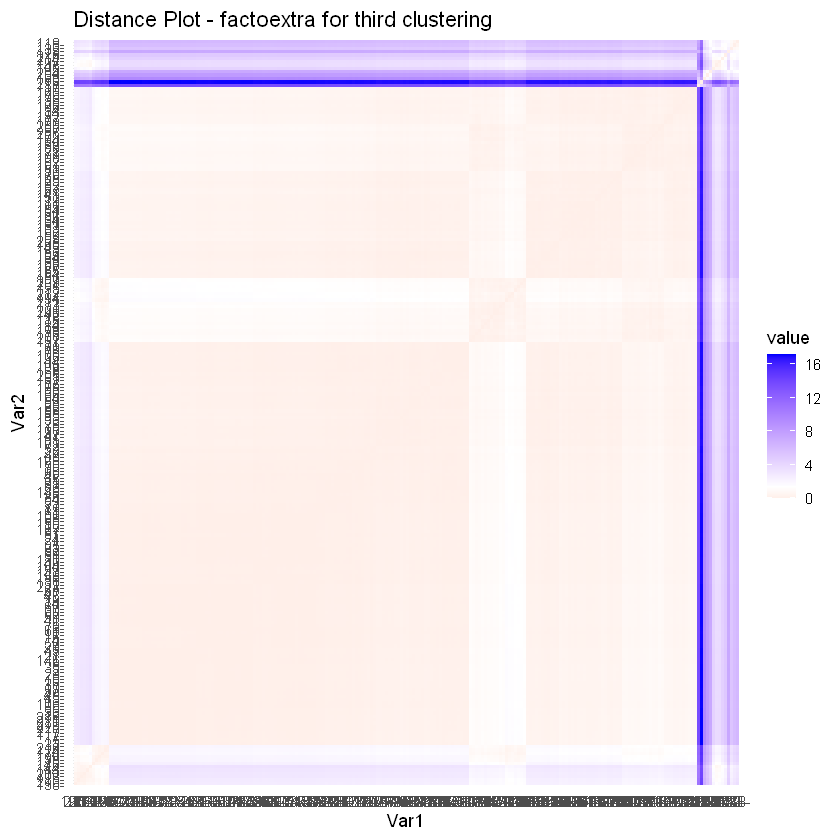

In [795]:
# K-means clustering using specific number of clusters
k_means_third_new <- kmeans(dataset_plus_census_scaled_third, centers=5, nstart = 10)

# Euclidean distance for the third dataset
d_third_new <- dist(dataset_plus_census_scaled_third)

# Create ggdissplot
diss_plot_third <- ggdissplot(d_third_new, labels = k_means_third_new$cluster) +
  ggtitle("Distance Matrix - Third K-means Clustering") +
  theme_minimal()

# Create factoextra plot
fviz_plot_third <- fviz_dist(d_third_new) +
  ggtitle("Distance Plot - factoextra for third clustering") +
  theme_minimal()

# Display the plots
print(diss_plot_third)
print(fviz_plot_third)


We might need 3 clusters for this dataset.

In [789]:
# Save the plots
ggsave("distance_plot_third.png", plot = diss_plot_third, width = 10, height = 10)
ggsave("factoextra_plot_third.png", plot = fviz_plot_third, width = 10, height = 10)

### Determine suitable number of clusters

#### Average Silhouette Width

[1] 2


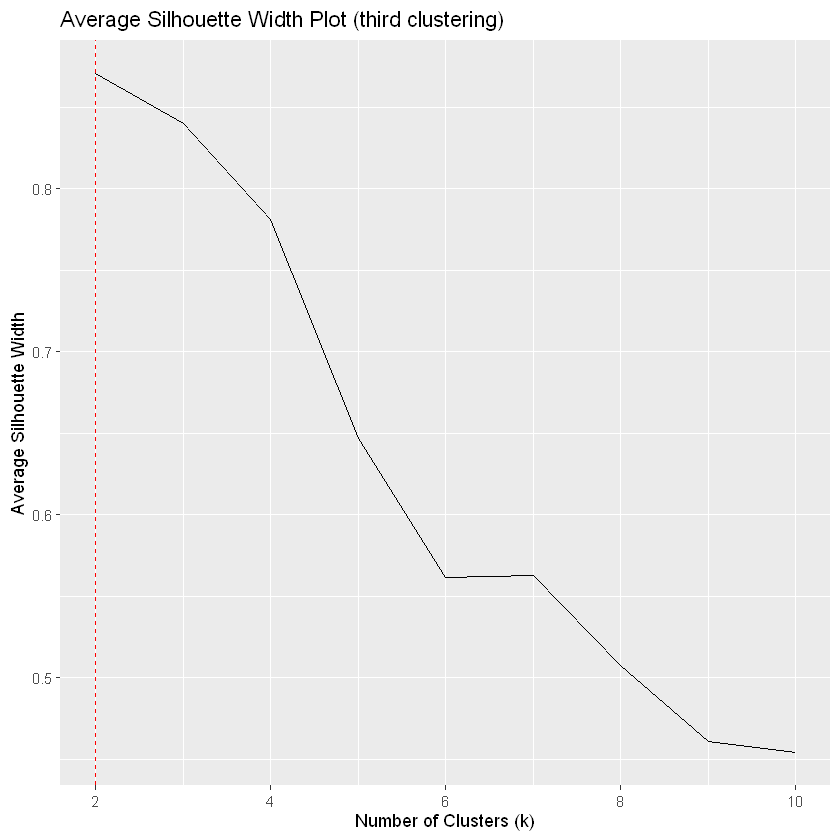

In [796]:
# range for number of clusters
ks_third <- 2:10

# distance
d_third <- dist(dataset_plus_census_scaled_third)

# Average Silhouette Width
ASW_third <- sapply(ks_third, FUN=function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_third, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_third)
  mean(silhouette_info[, 3]) 
})

# best k
best_k_third <- ks_third[which.max(ASW_third)]
print(best_k_third)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_third, ASW_third), aes(x = ks_third, y = ASW_third)) + 
  geom_line() +
  geom_vline(xintercept = best_k_third, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (third clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")


  cluster size ave.sil.width
1       1   12          0.35
2       2  210          0.90
  cluster size ave.sil.width
1       1  202          0.88
2       2    2          0.62
3       3   18          0.37
  cluster size ave.sil.width
1       1   16          0.48
2       2    2          0.53
3       3  196          0.82
4       4    8          0.39
  cluster size ave.sil.width
1       1    6          0.41
2       2   22          0.28
3       3    2          0.50
4       4   12          0.37
5       5  126          0.70
6       6   54          0.41


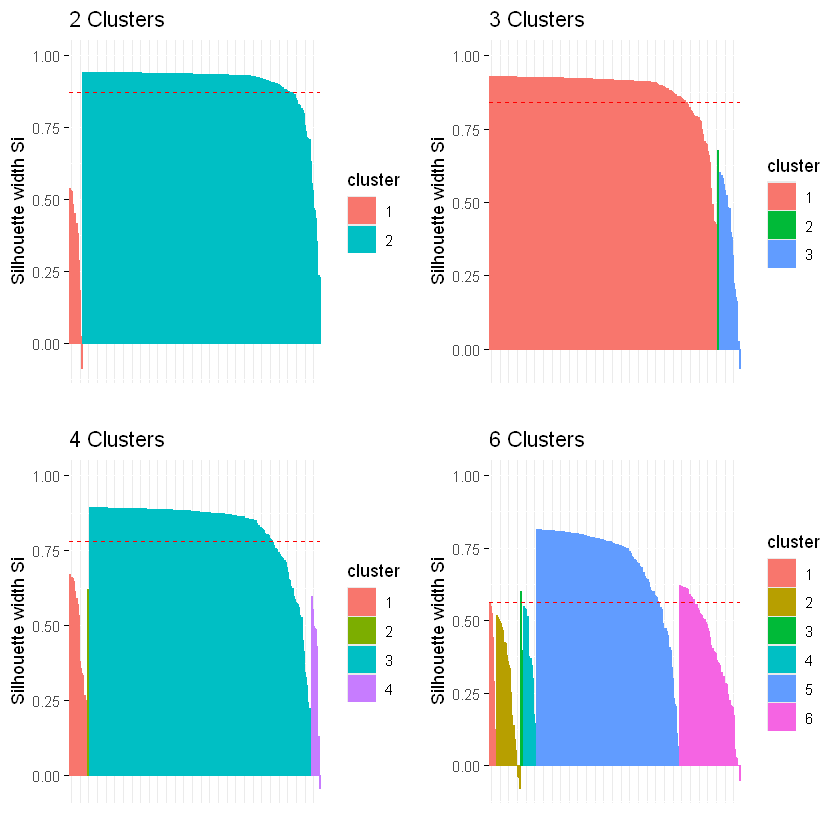

In [797]:
# K-means clustering (10 random restarts)
k_means_third_first <- kmeans(dataset_plus_census_scaled_third, centers=2, nstart = 10)
k_means_third_second <- kmeans(dataset_plus_census_scaled_third, centers=3, nstart = 10)
k_means_third_third <- kmeans(dataset_plus_census_scaled_third, centers=4, nstart = 10)
k_means_third_fourth <- kmeans(dataset_plus_census_scaled_third, centers=6, nstart = 10)

# Compute silhouette scores
sil_third_first <- silhouette(k_means_third_first$cluster, d_third)
sil_third_second <- silhouette(k_means_third_second$cluster, d_third)
sil_third_third <- silhouette(k_means_third_third$cluster, d_third)
sil_third_fourth <- silhouette(k_means_third_fourth$cluster, d_third)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_third_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_third_second) + ggtitle("3 Clusters")
p3 <- fviz_silhouette(sil_third_third) + ggtitle("4 Clusters")
p4 <- fviz_silhouette(sil_third_fourth) + ggtitle("6 Clusters")

# Arrange the plots side by side in a 2x2 grid (note the empty space)
combined_silplot_third <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_third)


Based on this analysis, 2 clusters appears to be the most optimal choice for this dataset, as it has the highest silhouette width for the largest cluster.

#### Elbow Method: Within-Cluster Sum of Square

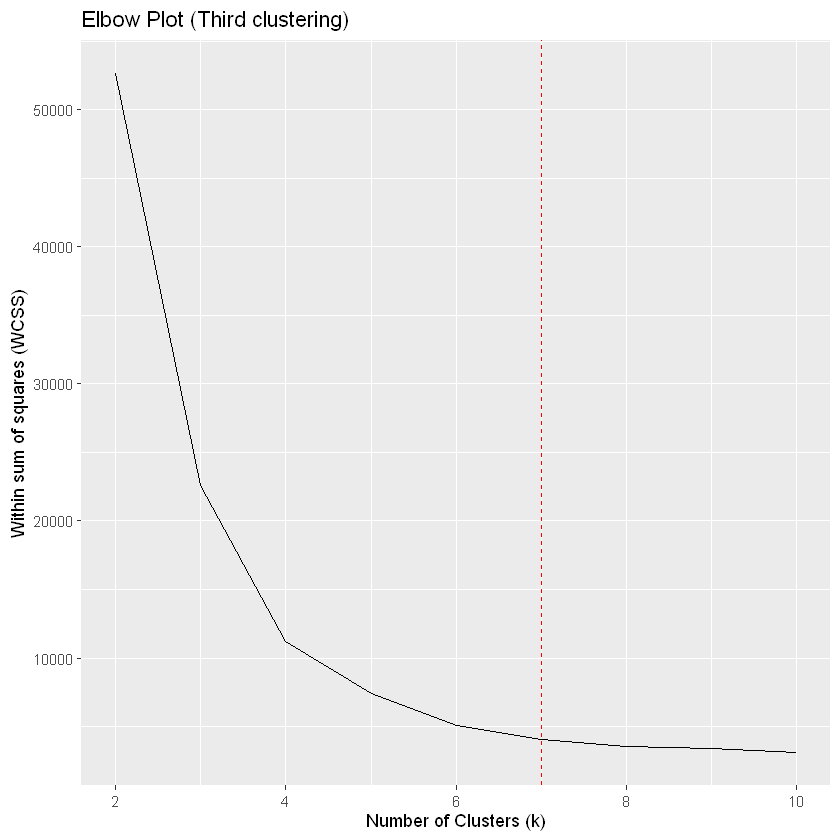

In [798]:
# Calculate within-cluster sum of squares for number of clusters
WCSS_third <- sapply(ks_first, FUN = function(k) {
  kmeans(dist(dataset_plus_census_scaled_third), centers = k, nstart = 10)$tot.withinss
})

# Plot 
ggplot(tibble(ks_third, WCSS_third), aes(ks_third, WCSS_third)) + 
  geom_line() +
  geom_vline(xintercept = 7, color = "red", linetype = 2) +
  ggtitle("Elbow Plot (Third clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")


Looks like 7 clusters is optimum

#### Gap Statistic

Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"
Warning message:
"did not converge in 10 iterations"


Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_third, FUNcluster = kmeans, K.max = 20, nstart = 10)
B=100 simulated reference sets, k = 1..20; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.317867 5.795491 1.477624 0.02630760
 [2,] 3.846360 5.185912 1.339552 0.02421500
 [3,] 3.592463 4.879027 1.286564 0.02128137
 [4,] 3.382297 4.696313 1.314016 0.01887807
 [5,] 3.061694 4.573927 1.512232 0.01514029
 [6,] 2.886828 4.487992 1.601164 0.01628833
 [7,] 2.785736 4.423790 1.638055 0.01876983
 [8,] 2.656634 4.373915 1.717281 0.01977619
 [9,] 2.562101 4.330250 1.768149 0.02060359
[10,] 2.503437 4.289858 1.786421 0.02011434
[11,] 2.412796 4.252523 1.839728 0.01885051
[12,] 2.374647 4.216078 1.841431 0.01828499
[13,] 2.331963 4.182052 1.850089 0.01925496
[14,] 2.305172 4.150560 1.845387 0.01881034
[15,] 2.272597 4.119627 1.847029 0.01842146
[16,] 2.261626 4.090942 1.82931

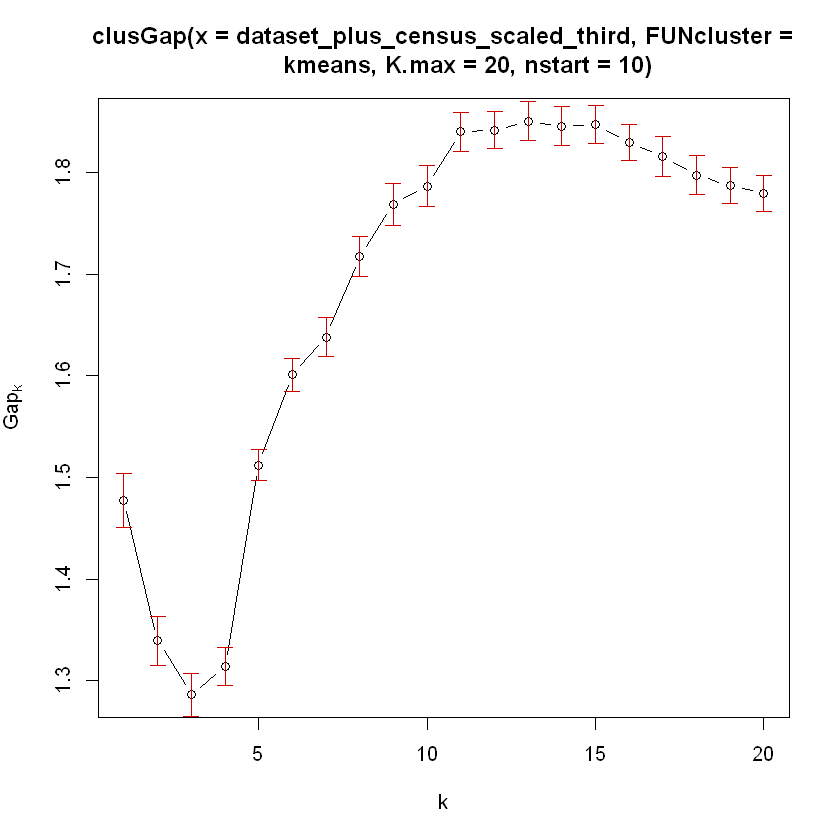

In [799]:
k_gap_third <- clusGap(dataset_plus_census_scaled_third, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 20)
k_gap_third

plot(k_gap_third)

Based on this we can say that 11 is the optimum number of clusters.

### Compare clusters (unsupervised)

In [749]:
# k-means clustering with different numbers of clusters
k_means_third_2 <- kmeans(dataset_plus_census_scaled_third, centers = 2)
k_means_third_3 <- kmeans(dataset_plus_census_scaled_third, centers = 3)
k_means_third_5 <- kmeans(dataset_plus_census_scaled_third, centers = 5)
k_means_third_6 <- kmeans(dataset_plus_census_scaled_third, centers = 6)

# Euclidean distance for third
d_third <- dist(dataset_plus_census_scaled_third)

# Compute clustering statistics for each clustering result
cluster_stats_third <- sapply(
  list(
    km_third_2 = k_means_third_2$cluster,
    km_third_3 = k_means_third_3$cluster,
    km_third_5 = k_means_third_5$cluster,
    km_third_6 = k_means_third_6$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_third, x)
)

# Extract the desired statistics
third_cluster_stats <- cluster_stats_third[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(third_cluster_stats)


                  km_third_2 km_third_3 km_third_5 km_third_6 
within.cluster.ss 283.8065   129.9854   46.36307   39.78291   
avg.silwidth      0.8703733  0.8400603  0.6465164  0.5617945  
pearsongamma      0.8150192  0.7699686  0.4882054  0.3815488  
dunn              0.04766757 0.08112688 0.01734194 0.007537748


2 clusters have the highest average silhouette width (0.8704) and a reasonably good Dunn index (0.0477), suggesting that they are well-separated with relatively good compactness. 3 clusters show some improvement in compactness (lower within-cluster SS) and Dunn index, but the silhouette width drops slightly, indicating slightly worse separation compared to 2 clusters. 5 and 6 clusters show even better compactness (lower within-cluster SS) but much worse separation (lower silhouette width and Dunn index), indicating that splitting into more clusters might lead to smaller and less well-defined clusters. Therefore, based on the silhouette width, 2 clusters appears to be the optimal choice as it balances both compactness and separation.

#### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse


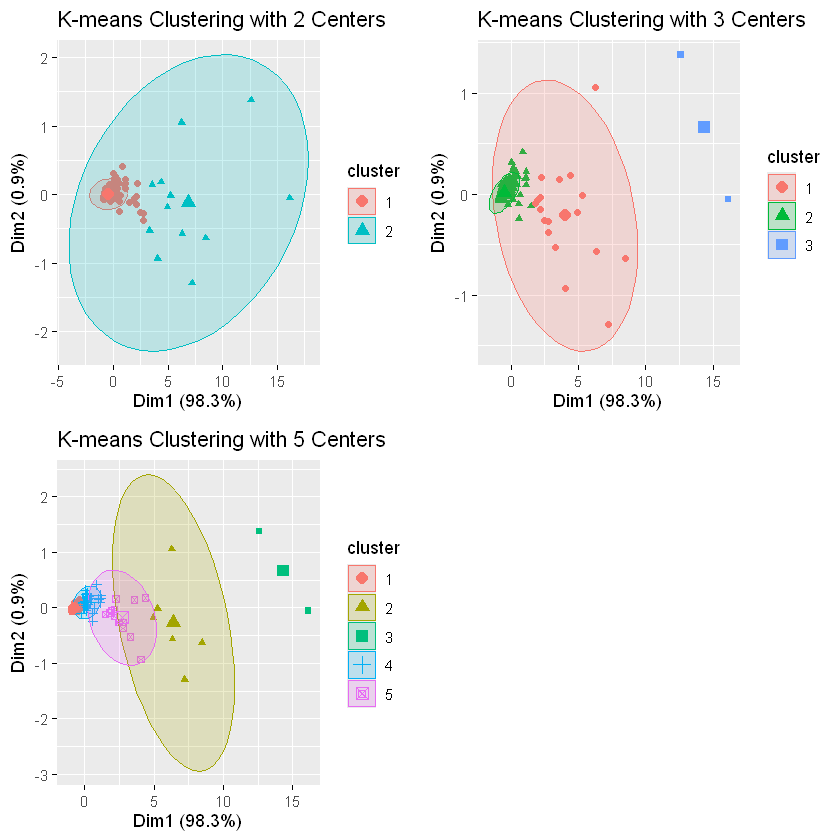

In [750]:
# K-means clustering with 2 clusters
kmeans_third_first <- kmeans(dataset_plus_census_scaled_third, centers = 2)
plot_kmeans_third_first <- fviz_cluster(kmeans_third_first, data = dataset_plus_census_scaled_third,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_third_second <- kmeans(dataset_plus_census_scaled_third, centers = 3)
plot_kmeans_third_second <- fviz_cluster(kmeans_third_second, data = dataset_plus_census_scaled_third,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 3 Centers")

# K-means clustering with 5 clusters
kmeans_third_third <- kmeans(dataset_plus_census_scaled_third, centers = 5)
plot_kmeans_third_third <- fviz_cluster(kmeans_third_third, data = dataset_plus_census_scaled_third,
                              centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 5 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_third <- ggarrange(plot_kmeans_third_first, plot_kmeans_third_second, plot_kmeans_third_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_third)

# Save the plot
ggsave("combined_plot_third.png", plot = combined_plot_third, width = 6, height = 3)


2 clusters is the optimum number of clusters.

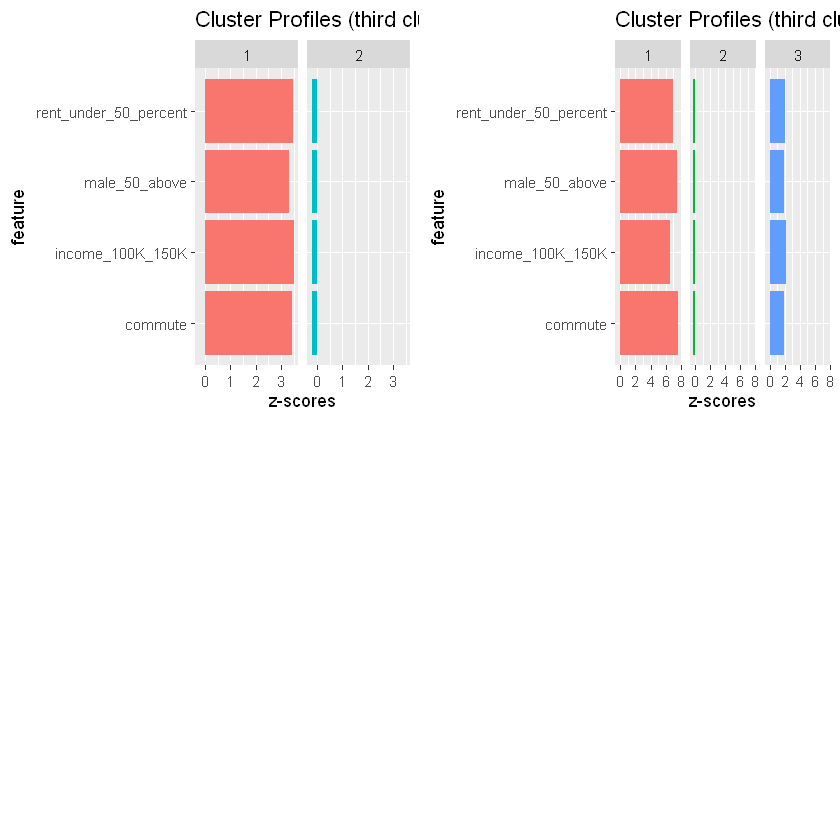

In [751]:
# Perform k-means clustering with 2 centers
k_means_third_2 <- kmeans(dataset_plus_census_scaled_third, centers = 2, nstart = 10)

cluster_profile_third_2 <- ggplot(pivot_longer(as_tibble(k_means_third_2$centers,  rownames = "cluster"), 
  cols = colnames(k_means_third_2$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (third clustering) with 2 clusters") + 
  guides(fill = "none")


# Perform k-means clustering with 3 centers
k_means_third_3 <- kmeans(dataset_plus_census_scaled_third, centers = 3, nstart = 10)

cluster_profile_third_3 <- ggplot(pivot_longer(as_tibble(k_means_third_3$centers,  rownames = "cluster"), 
  cols = colnames(k_means_third_3$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (third clustering) with 3 clusters") + 
  guides(fill = "none")


# Arrange the plots side by side in a 2x2 grid
combined_cluster_profile_third <- ggarrange(cluster_profile_third_2, cluster_profile_third_3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_cluster_profile_third)

# Save the plot
ggsave("combined_cluster_profile_third.png", plot = combined_cluster_profile_third, width = 5, height = 5)


We only need 2 clusters.

In [752]:
k_means_third_2

K-means clustering with 2 clusters of sizes 12, 210

Cluster means:
  income_100K_150K rent_under_50_percent male_50_above   commute
1        3.5035304              3.471930     3.3300288  3.448831
2       -0.2002017             -0.198396    -0.1902874 -0.197076

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 1 2 2 2 1 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
[186] 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 2 2

Within cluster sum of squares by cluster:
[1] 174.9414 108.8651
 (between_SS / total_SS =  67.9 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         

### Heat map

In [756]:
# Load the dataset
dataset_third_heatmap <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_third_heatmap <- dataset_third_heatmap %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_third_heatmap <- dataset_third_heatmap %>% filter(state == "TX")

# Filter the dataset
dataset_third_heatmap <- dataset_third_heatmap %>%
  filter(!(county_name %in% counties_to_exclude))

# Select the features
dataset_third_heatmap <- dataset_third_heatmap %>%  
  select(county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K, female_21_49, worked_at_home)

# Per 1000
dataset_third_heatmap <- dataset_third_heatmap %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

# remove County from the names and convert them to lowercase
dataset_third_heatmap <- dataset_third_heatmap %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX <- right_join(counties_polygon_TX, dataset_third_heatmap)

# Scaling
dataset_third_heatmap_scaled <- dataset_third_heatmap %>% 
  select(hispanic_pop, income_50K_100K, female_21_49, worked_at_home) %>% 
  scale() %>% as_tibble()

# k means setting
km_third_heatmap <- kmeans(dataset_third_heatmap_scaled, centers = 2, nstart = 10)

# Add the cluster labels to the dataset
dataset_plus_census_third_clust_heatmap <- dataset_third_heatmap %>% 
    add_column(cluster = factor(km_third_heatmap$cluster))

# Database join
counties_polygon_TX_third_clust_third <- right_join(counties_polygon_TX, dataset_plus_census_third_clust_heatmap, 
                                        join_by(county))


Joining with `by = join_by(county, county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K,
cases_per_1000, deaths_per_1000, death_per_case, female_21_49, worked_at_home)`


In [757]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_third_clust_third$county))

[1] 222

[1] "bell"    "cameron" "el paso" "hidalgo" "nueces" 


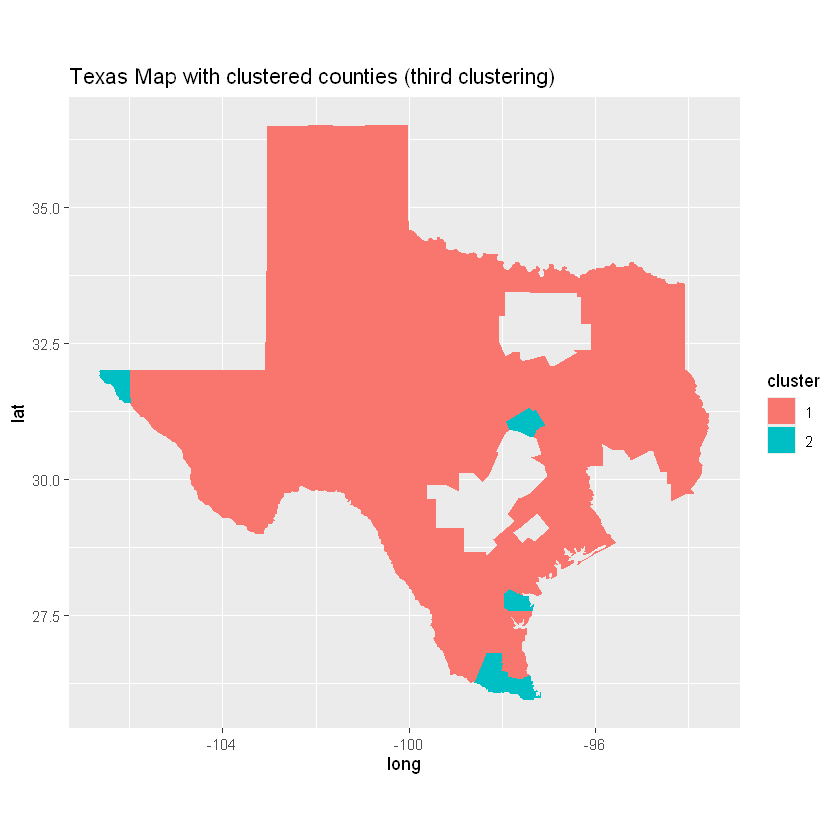

In [759]:
# heat map
ggplot(counties_polygon_TX_third_clust_third, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (third clustering)")

# Filter for counties in cluster 1
counties_cluster_1 <- counties_polygon_TX_second_clust %>%
  filter(cluster == 1)

# Print the counties in cluster 1
print(unique(counties_cluster_1$county))

In [802]:
dataset_plus_census_third_clust_heatmap %>% group_by(cluster) %>% summarize(
  avg_cases_per_1000 = mean(cases_per_1000), 
  avg_deaths_per_1000 = mean(deaths_per_1000))

cluster,avg_cases_per_1000,avg_deaths_per_1000
<fct>,<dbl>,<dbl>
1,78.72391,1.986519
2,82.40390,1.897068


In [476]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_work_rent<- hopkins(dataset_plus_census_scaled_work_rent)
hopkins_stat_work_rent

[1] 1

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_work_rent, FUNcluster = kmeans, K.max = 10, nstart = 10)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.558170 6.180481 1.622311 0.02256739
 [2,] 4.121218 5.716166 1.594949 0.01828760
 [3,] 3.851278 5.526707 1.675429 0.01833902
 [4,] 3.645985 5.426734 1.780749 0.01816633
 [5,] 3.433628 5.349836 1.916207 0.01690117
 [6,] 3.348285 5.280300 1.932015 0.01678579
 [7,] 3.236735 5.219146 1.982412 0.01583259
 [8,] 3.198813 5.166039 1.967226 0.01581566
 [9,] 3.159085 5.119618 1.960533 0.01546418
[10,] 3.035652 5.082054 2.046402 0.01568236

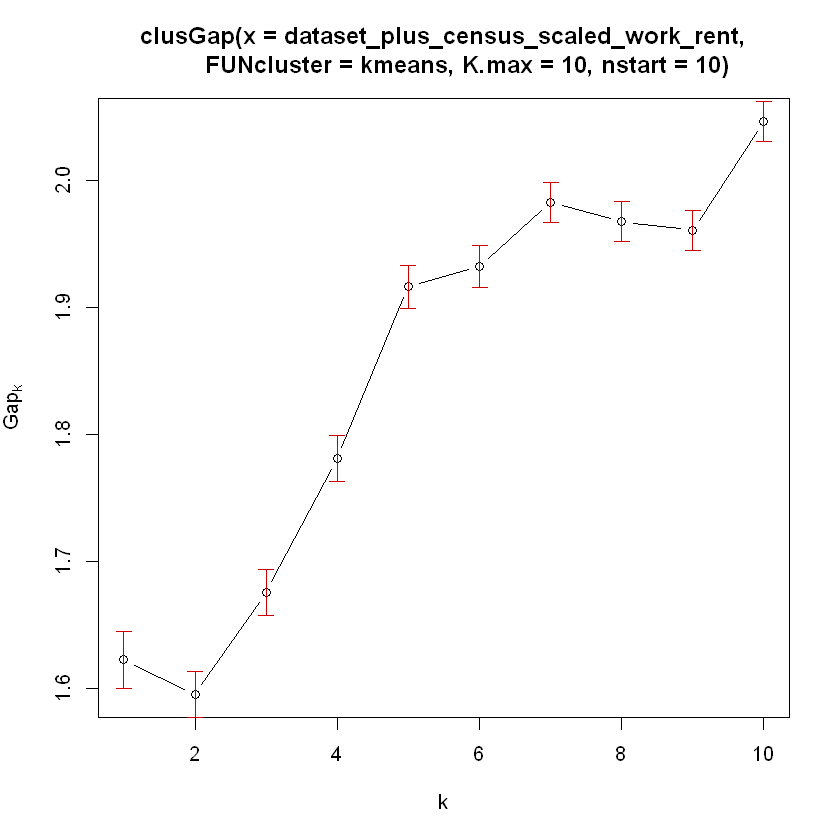

In [580]:
k_gap_work_rent <- clusGap(dataset_plus_census_scaled_work_rent, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 10)
k_gap_work_rent

plot(k_gap_work_rent)

## K-means (Euclidean distance) for variables related to hispanic race, income of 50-100K,  male of aged between 21-49, commute to work, and spends over 50% on rent. 

In [599]:
# Prepare the dataset with columns related to income ranges and races
dataset_plus_census_fourth <- dataset_plus_census %>% 
  select(hispanic_pop, income_50K_100K, male_21_49, commute, rent_over_50_percent) %>% 
  scale() %>% as_tibble()

# Scale the dataset
dataset_plus_census_scaled_fourth <- scale(dataset_plus_census_fourth)

In [600]:
dataset_plus_census_scaled_fourth_summary <- summary(dataset_plus_census_scaled_fourth)

dataset_plus_census_scaled_fourth_summary

  hispanic_pop     income_50K_100K      male_21_49          commute       
 Min.   :-0.2510   Min.   :-0.48025   Min.   :-0.42670   Min.   :-0.4412  
 1st Qu.:-0.2321   1st Qu.:-0.42067   1st Qu.:-0.37657   1st Qu.:-0.3834  
 Median :-0.2031   Median :-0.31755   Median :-0.29161   Median :-0.3081  
 Mean   : 0.0000   Mean   : 0.00000   Mean   : 0.00000   Mean   : 0.0000  
 3rd Qu.:-0.1235   3rd Qu.:-0.06348   3rd Qu.:-0.09854   3rd Qu.:-0.0800  
 Max.   : 9.7590   Max.   : 8.07375   Max.   : 8.31051   Max.   : 8.2967  
 rent_over_50_percent
 Min.   :-0.3775     
 1st Qu.:-0.3553     
 Median :-0.3095     
 Mean   : 0.0000     
 3rd Qu.:-0.1573     
 Max.   : 6.8913     

In [601]:
write.csv(dataset_plus_census_scaled_fourth_summary, "dataset_plus_census_scaled_fourth_summary.csv", row.names = FALSE)

In [602]:
head(dataset_plus_census_scaled_fourth)

hispanic_pop,income_50K_100K,male_21_49,commute,rent_over_50_percent
-0.2177805,-0.4293063,-0.3723423,-0.3828995,-0.3587714
-0.2479489,-0.4678877,-0.4213278,-0.4307855,-0.3753124
-0.2294297,-0.4543727,-0.4054166,-0.4113773,-0.3569335
-0.2181961,-0.4308079,-0.4005129,-0.3969089,-0.3396574
-0.2177546,-0.3700479,-0.3565876,-0.3534498,-0.2940779
-0.2339102,-0.4430524,-0.3968611,-0.4025235,-0.3620796


In [603]:
# Compute the Hopkins statistic
set.seed(123) 
hopkins_stat_fourth <- hopkins(dataset_plus_census_scaled_fourth)
hopkins_stat_fourth

[1] 1

### Factoextra & Distance/Dissimilarity plots

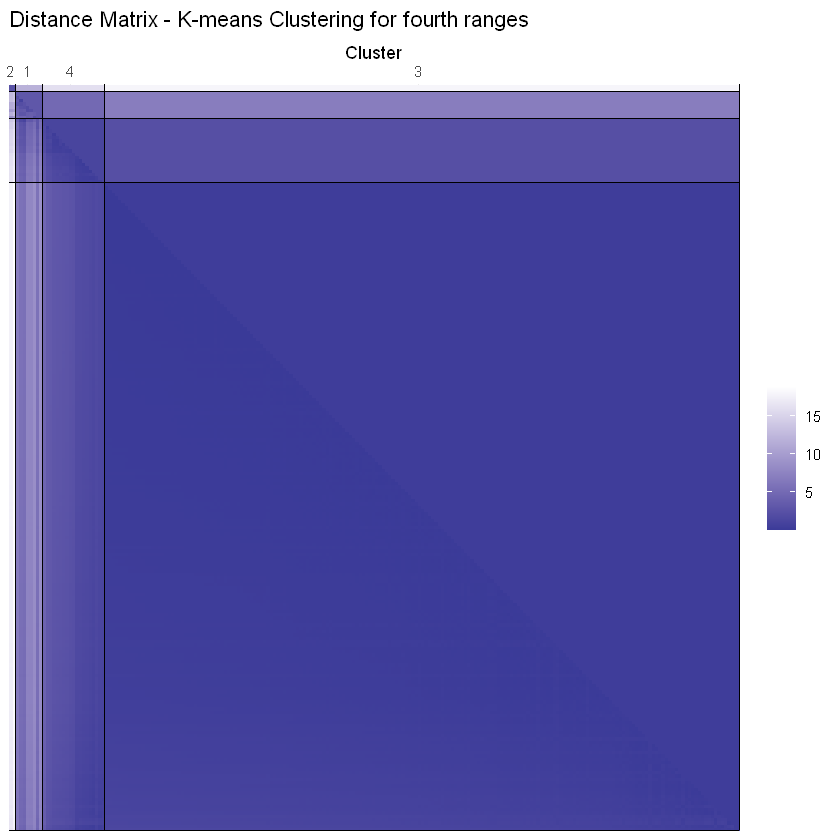

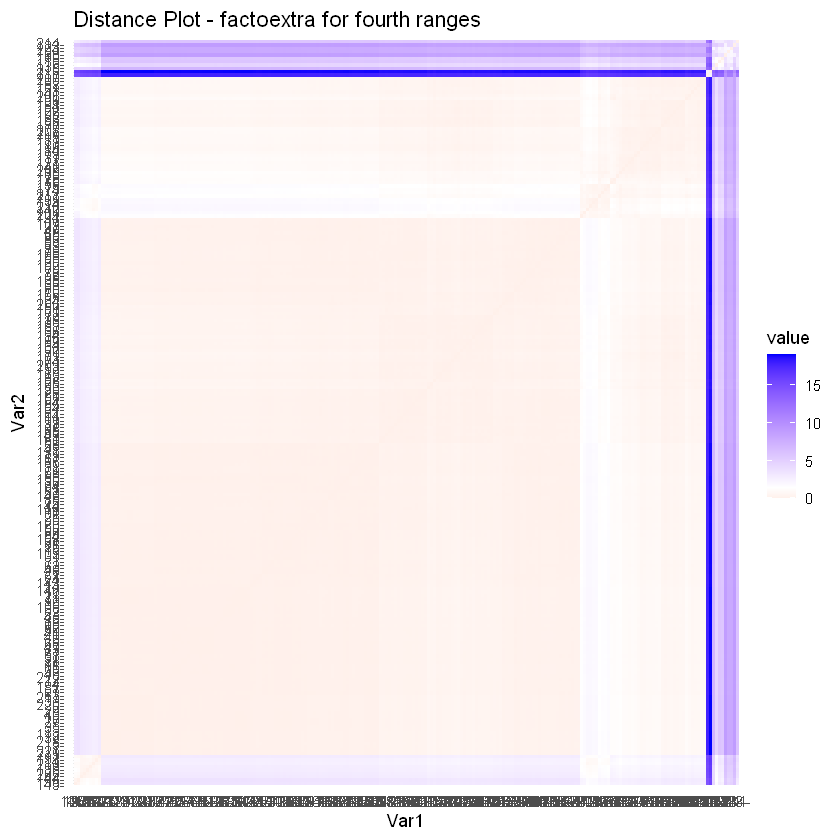

In [605]:
# K-means clustering using specific number of clusters
k_means_fourth_new <- kmeans(dataset_plus_census_scaled_fourth, centers = 4, nstart = 10)

# Euclidean distance for incomes
d_fourth_new <- dist(dataset_plus_census_scaled_fourth)

# Create ggdissplot
diss_plot_fourth <- ggdissplot(d_fourth_new, labels = k_means_fourth_new$cluster) +
  ggtitle("Distance Matrix - K-means Clustering for fourth ranges") +
  theme_minimal()

# Create factoextra plot
fviz_plot_fourth <- fviz_dist(d_fourth_new) +
  ggtitle("Distance Plot - factoextra for fourth ranges") +
  theme_minimal()

diss_plot_fourth
fviz_plot_fourth


In [804]:
# Save the plots
ggsave("distance_plot_fourth.png", plot = diss_plot_fourth, width = 10, height = 10)
ggsave("factoextra_plot_fourth.png", plot = fviz_plot_fourth, width = 10, height = 10)

### Determine suitable number of clusters

#### Average Silhouette Width

[1] 2


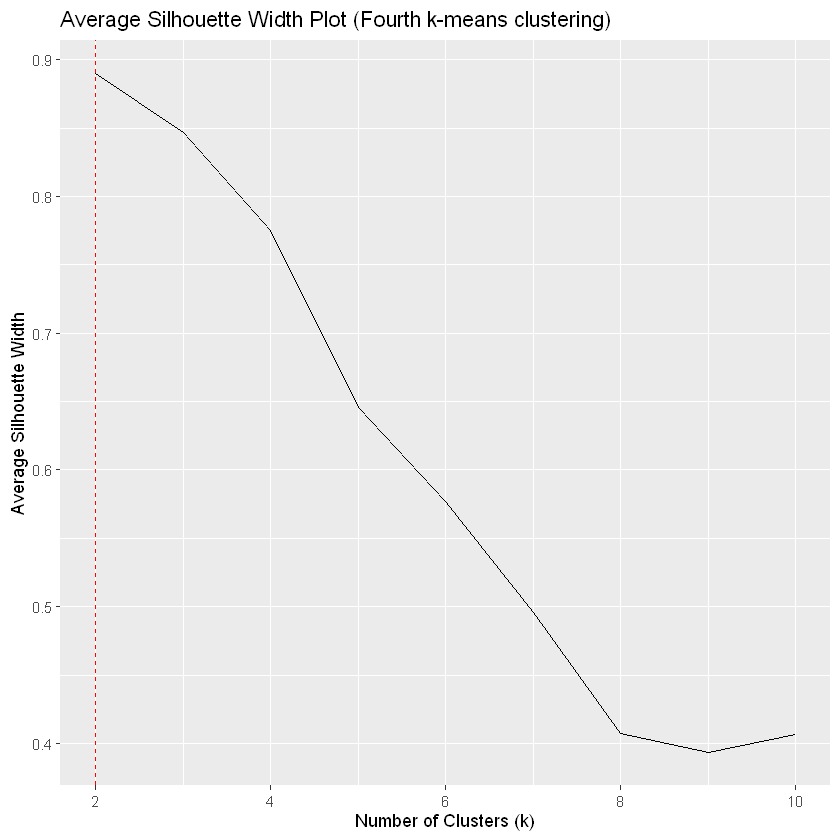

In [606]:
# Range for number of clusters
ks_fourth <- 2:10

# Distance
d_fourth <- dist(dataset_plus_census_scaled_fourth)

# Average Silhouette Width
ASW_fourth <- sapply(ks_fourth, FUN = function(k) {
  kmeans_result <- kmeans(dataset_plus_census_scaled_fourth, centers = k, nstart = 10)
  silhouette_info <- silhouette(kmeans_result$cluster, d_fourth)
  mean(silhouette_info[, 3])  # Return the average silhouette width
})

# Best k
best_k_fourth <- ks_fourth[which.max(ASW_fourth)]
print(best_k_fourth)

# Plot the Average Silhouette Width
ggplot(data.frame(ks_fourth, ASW_fourth), aes(x = ks_fourth, y = ASW_fourth)) + 
  geom_line() +
  geom_vline(xintercept = best_k_fourth, color = "red", linetype = 2) + 
  ggtitle("Average Silhouette Width Plot (Fourth k-means clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Average Silhouette Width")


  cluster size ave.sil.width
1       1  212          0.92
2       2   10          0.26
  cluster size ave.sil.width
1       1  193          0.83
2       2   19          0.41
3       3    2          0.79
4       4    8          0.35
  cluster size ave.sil.width
1       1  146          0.70
2       2    2          0.79
3       3   11          0.44
4       4   10          0.39
5       5   45          0.31
6       6    8          0.24
  cluster size ave.sil.width
1       1    9          0.40
2       2   17          0.08
3       3    2          0.79
4       4    8          0.24
5       5   54          0.36
6       6   10          0.36
7       7   21          0.30
8       8  101          0.65


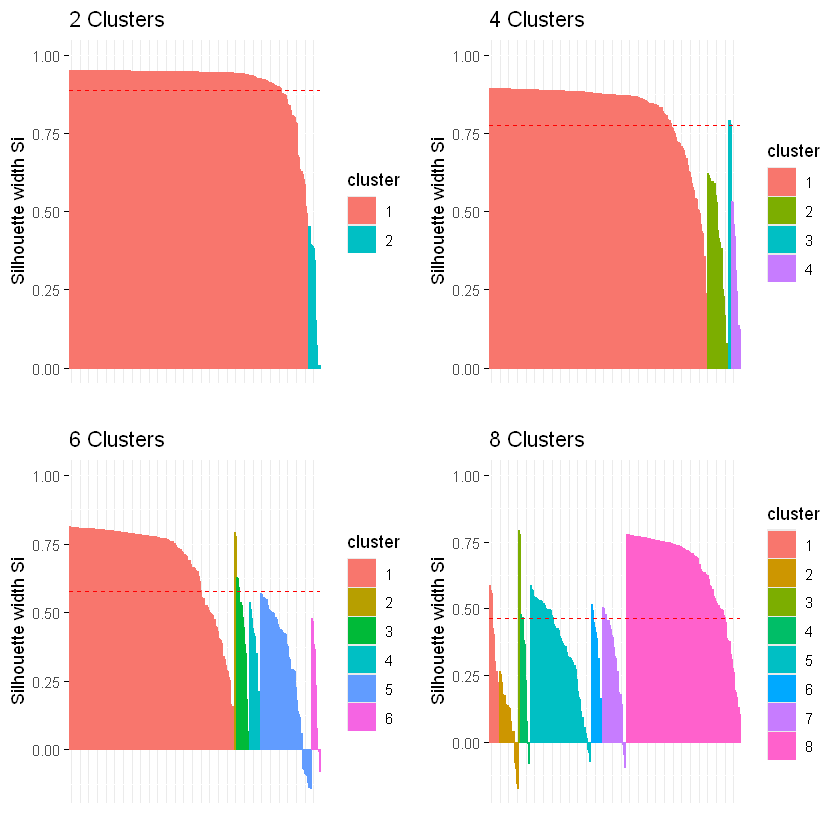

In [805]:
# K-means clustering (10 random restarts)
k_means_fourth_first <- kmeans(dataset_plus_census_scaled_fourth, centers = 2, nstart = 10)
k_means_fourth_second <- kmeans(dataset_plus_census_scaled_fourth, centers = 4, nstart = 10)
k_means_fourth_third <- kmeans(dataset_plus_census_scaled_fourth, centers = 6, nstart = 10)
k_means_fourth_fourth <- kmeans(dataset_plus_census_scaled_fourth, centers = 8, nstart = 10)

# Compute silhouette scores
sil_fourth_first <- silhouette(k_means_fourth_first$cluster, d_fourth)
sil_fourth_second <- silhouette(k_means_fourth_second$cluster, d_fourth)
sil_fourth_third <- silhouette(k_means_fourth_third$cluster, d_fourth)
sil_fourth_fourth <- silhouette(k_means_fourth_fourth$cluster, d_fourth)

# Visualize silhouette plots
p1 <- fviz_silhouette(sil_fourth_first) + ggtitle("2 Clusters")
p2 <- fviz_silhouette(sil_fourth_second) + ggtitle("4 Clusters")
p3 <- fviz_silhouette(sil_fourth_third) + ggtitle("6 Clusters")
p4 <- fviz_silhouette(sil_fourth_fourth) + ggtitle("8 Clusters")

# Arrange the plots side by side in a 2x2 grid
combined_silplot_fourth <- ggarrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_silplot_fourth)

For 2 clusters, the silhouette width is very high for the first cluster (0.92) but quite low for the second (0.26), indicating that the second cluster is not well-defined.  
For 4 clusters, the silhouette widths are relatively high for some clusters (0.83, 0.79), but lower for others (0.41, 0.35).  
For 6 clusters, the silhouette widths vary significantly, with some clusters having low values (0.24, 0.31) and others higher (0.70, 0.79).  
For 8 clusters, the silhouette widths are generally lower overall, with only one cluster having a high silhouette width (0.79), and several clusters having low values.  

Based on the provided silhouette widths, 4 clusters seems to provide a balance between the number of clusters and the quality of clustering. Although not all clusters have very high silhouette widths, the values are more consistent compared to the 6 and 8 cluster solutions, and better defined than the 2 cluster solution. Thus, 4 clusters appears to be the most optimal for your dataset, considering both the silhouette average widths and the distribution of cluster sizes.

#### Elbow Method: Within-Cluster Sum of Square

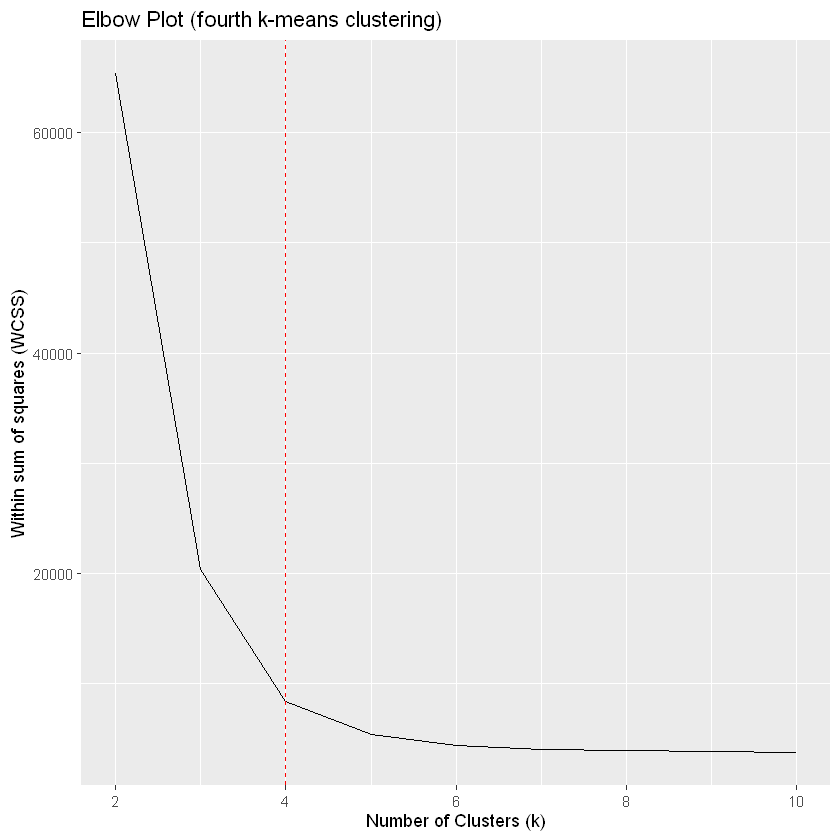

In [610]:
#Calculate within-cluster sum of squares for number of clusters
WCSS_fourth <- sapply(ks_fourth, FUN = function(k) {
  kmeans(d_fourth <- dist(dataset_plus_census_scaled_fourth), centers = k, nstart = 10)$tot.withinss
  })

# Plot 
ggplot(tibble(ks_fourth, WCSS_fourth), aes(ks_fourth, WCSS_fourth)) + 
  geom_line() +
  geom_vline(xintercept = 4, color = "red", linetype = 2)+
  ggtitle("Elbow Plot (fourth k-means clustering)") +
  xlab("Number of Clusters (k)") +
  ylab("Within sum of squares (WCSS)")

We can see that after 4 clusters, the sum of squares does not decrease that significantly indicating that 4 clusterings is optimum number of clusters for the dataset.

#### Gap Statistic

Clustering Gap statistic ["clusGap"] from call:
clusGap(x = dataset_plus_census_scaled_fourth, FUNcluster = kmeans, K.max = 10, nstart = 10)
B=100 simulated reference sets, k = 1..10; spaceH0="scaledPCA"
 --> Number of clusters (method 'firstSEmax', SE.factor=1): 1
          logW   E.logW      gap     SE.sim
 [1,] 4.348297 5.971197 1.622900 0.02411663
 [2,] 3.897557 5.464918 1.567360 0.02008068
 [3,] 3.620874 5.240562 1.619688 0.02131424
 [4,] 3.342931 5.118977 1.776046 0.01708003
 [5,] 3.101218 5.038691 1.937473 0.01700431
 [6,] 2.980739 4.969175 1.988436 0.01690901
 [7,] 2.836260 4.905416 2.069156 0.01728311
 [8,] 2.775237 4.846449 2.071211 0.01672223
 [9,] 2.740782 4.793962 2.053180 0.01712758
[10,] 2.707005 4.747091 2.040087 0.01744596

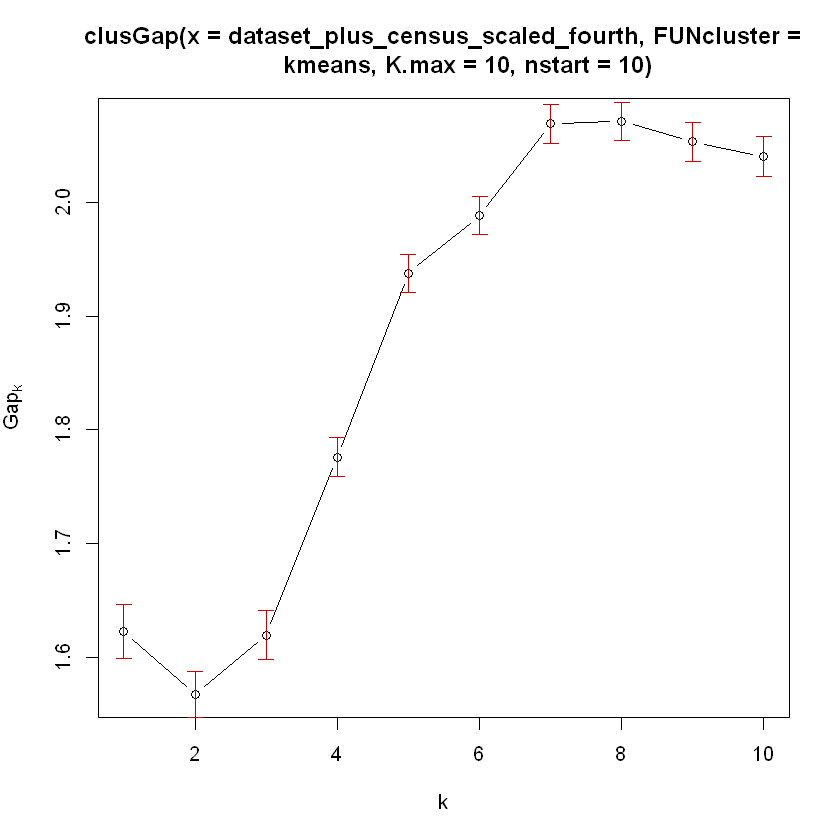

In [611]:
k_gap_fourth <- clusGap(dataset_plus_census_scaled_fourth, 
             FUN = kmeans,  
             nstart = 10, 
             K.max = 10)
k_gap_fourth

plot(k_gap_fourth)

Indicates 11 clusters is optimum number of clusters.

### Compare clusters (unsupervised)

In [612]:
# k-means clustering with different numbers of clusters
k_means_fourth_first <- kmeans(dataset_plus_census_scaled_fourth, centers = 2)
k_means_fourth_second <- kmeans(dataset_plus_census_scaled_fourth, centers = 4)
k_means_fourth_third <- kmeans(dataset_plus_census_scaled_fourth, centers = 8)
k_means_fourth_fourth <- kmeans(dataset_plus_census_scaled_fourth, centers = 10)

# Compute clustering statistics for each clustering result
cluster_stats <- sapply(
  list(
    km_first = k_means_fourth_first$cluster,
    km_second = k_means_fourth_second$cluster,
    km_third = k_means_fourth_third$cluster,
    km_fourth = k_means_fourth_fourth$cluster
  ),
  FUN = function(x) fpc::cluster.stats(d_fourth, x)
)

# Extract the desired statistics
fourth_cluster_stats <- cluster_stats[c("within.cluster.ss", "avg.silwidth", "pearsongamma", "dunn"), ]

# Print the results
print(fourth_cluster_stats)


                  km_first   km_second  km_third    km_fourth 
within.cluster.ss 380.2993   76.5326    50.10439    49.19994  
avg.silwidth      0.8896608  0.7753996  0.4071046   0.363984  
pearsongamma      0.8246153  0.655894   0.2225344   0.1924984 
dunn              0.08043983 0.05822636 0.004683524 0.00467794


We see highest average silhouette width, the highest Pearson gamma, and the highest Dunn index for clustering with only 2 clusters. This indicates that the clusters are well-separated and well-defined with 2 clusters.

#### Inspect the clusters (Visualization)

Too few points to calculate an ellipse
Too few points to calculate an ellipse


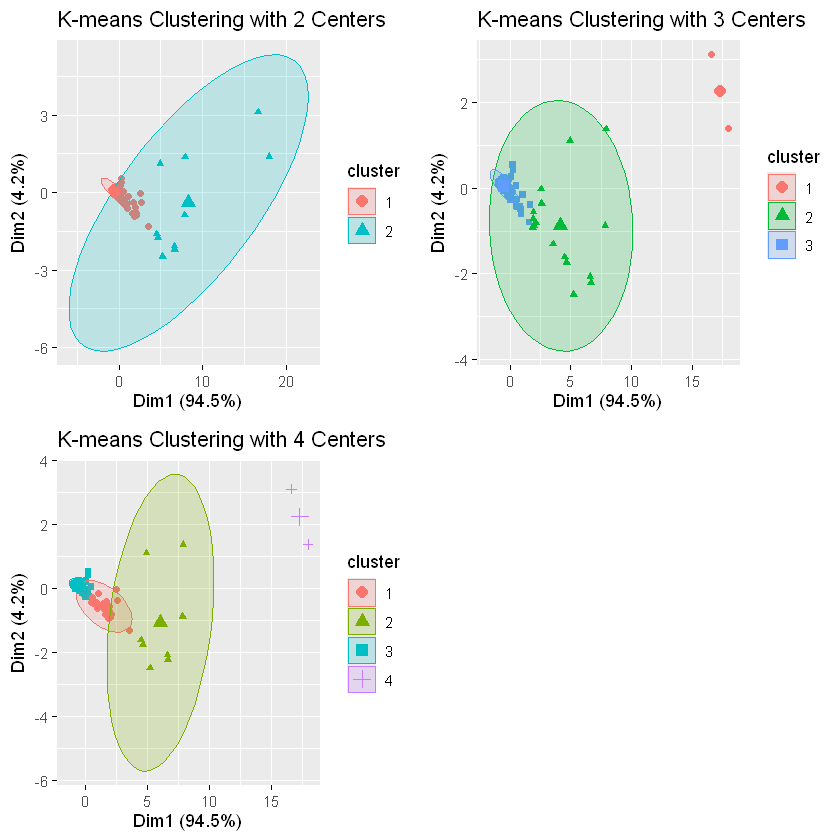

In [615]:
# K-means clustering with 2 clusters
kmeans_fourth_first <- kmeans(dataset_plus_census_scaled_fourth, centers = 2)
plot_kmeans_fourth_first <- fviz_cluster(kmeans_fourth_first, data = dataset_plus_census_scaled_fourth,
                                         centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 2 Centers")

# K-means clustering with 3 clusters
kmeans_fourth_second <- kmeans(dataset_plus_census_scaled_fourth, centers = 3)
plot_kmeans_fourth_second <- fviz_cluster(kmeans_fourth_second, data = dataset_plus_census_scaled_fourth,
                                          centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 3 Centers")

# K-means clustering with 4 clusters
kmeans_fourth_third <- kmeans(dataset_plus_census_scaled_fourth, centers = 4)
plot_kmeans_fourth_third <- fviz_cluster(kmeans_fourth_third, data = dataset_plus_census_scaled_fourth,
                                         centroids = TRUE, geom = "point", ellipse.type = "norm") +
  labs(title = "K-means Clustering with 4 Centers")

# Arrange the plots side by side in a 2x2 grid
combined_plot_fourth <- ggarrange(plot_kmeans_fourth_first, plot_kmeans_fourth_second, plot_kmeans_fourth_third, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_plot_fourth)

# Save the plot
ggsave("combined_plot_fourth.png", plot = combined_plot_fourth, width = 6, height = 3)


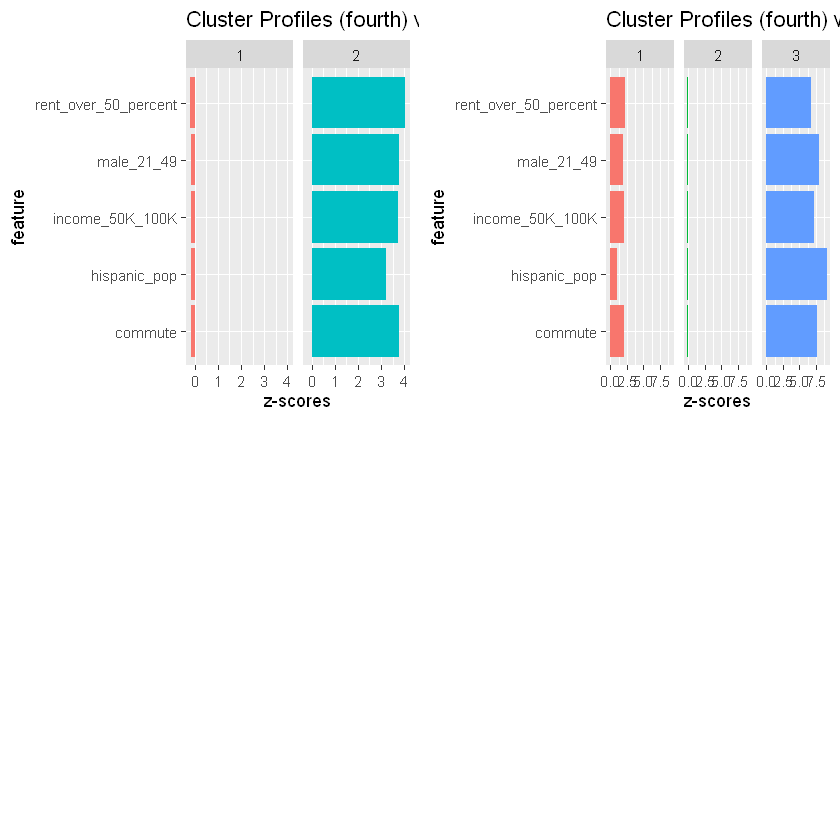

In [616]:
# Perform k-means clustering with 2 centers
k_means_fourth_2 <- kmeans(dataset_plus_census_scaled_fourth, centers = 2, nstart = 10)

cluster_profile_fourth_2 <- ggplot(pivot_longer(as_tibble(k_means_fourth_2$centers,  rownames = "cluster"), 
  cols = colnames(k_means_fourth_2$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (fourth) with 2 clusters") + 
  guides(fill = "none")

# Perform k-means clustering with 3 centers
k_means_fourth_3 <- kmeans(dataset_plus_census_scaled_fourth, centers = 3, nstart = 10)

cluster_profile_fourth_3 <- ggplot(pivot_longer(as_tibble(k_means_fourth_3$centers,  rownames = "cluster"), 
  cols = colnames(k_means_fourth_3$centers)), 
  aes(y = name, x = value, fill = cluster)) +
  geom_bar(stat = "identity") +
  facet_grid(cols = vars(cluster)) +
  labs(y = "feature", x = "z-scores", title = "Cluster Profiles (fourth) with 3 clusters") + 
  guides(fill = "none")

# Arrange the plots side by side in a 2x2 grid
combined_cluster_profile_fourth <- ggarrange(cluster_profile_fourth_2, cluster_profile_fourth_3, ncol = 2, nrow = 2)

# Display the combined plot
print(combined_cluster_profile_fourth)

# Save the plot
ggsave("combined_cluster_profile_fourth.png", plot = combined_cluster_profile_fourth, width = 5, height = 5)


In [621]:
k_means_fourth_2
k_means_fourth_3

K-means clustering with 2 clusters of sizes 212, 10

Cluster means:
  hispanic_pop income_50K_100K male_21_49    commute rent_over_50_percent
1   -0.1514423      -0.1761111  -0.177640 -0.1782435           -0.1915864
2    3.2105757       3.7335559   3.765968  3.7787622            4.0616325

Clustering vector:
  [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [75] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[112] 1 2 1 1 1 2 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1

Within cluster sum of squares by cluster:
[1] 120.6190 259.6804
 (between_SS / total_SS =  65.6 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "be

K-means clustering with 3 clusters of sizes 16, 204, 2

Cluster means:
  hispanic_pop income_50K_100K male_21_49   commute rent_over_50_percent
1    1.0169286       2.1142494  1.8993475  2.049169            2.2443608
2   -0.1700487      -0.2364724 -0.2275466 -0.235580           -0.2417451
3    9.2095423       7.2061905  8.0149778  7.635808            6.7031121

Clustering vector:
  [1] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
[112] 2 1 2 2 2 3 1 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 1 2 2 2
[149] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
[186] 2 2 2 2 2 2 2 2 2 1 1 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 1 3 2 2 2 2 2 2

Within cluster sum of squares by cluster:
[1] 98.769446 49.878278  3.228287
 (between_SS / total_SS =  86.3 %)

Available components:

[

### Heat map

In [817]:
# Load the dataset
dataset_plus_census_heatmap_fourth <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")

dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>% mutate(across(where(is.character), factor))

# Filter by Texas
dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>% filter(state == "TX")

# Filter the dataset
dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>%
  filter(!(county_name %in% counties_to_exclude))

# Select the features
dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>%  
  select(county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K, female_21_49, worked_at_home)

# Per 1000
dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>% mutate(
  cases_per_1000 = confirmed_cases/total_pop*1000, 
  deaths_per_1000 = deaths/total_pop*1000, 
  death_per_case = deaths/confirmed_cases)

# remove County from the names and convert them to lowercase
dataset_plus_census_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>% mutate(county = county_name %>% 
    str_to_lower() %>% str_replace('\\s+county\\s*$', ''))

# Database join
counties_polygon_TX_fourth <- right_join(counties_polygon_TX, dataset_plus_census_heatmap_fourth)

# Scaling
dataset_plus_census_heatmap_fourth_scaled <- dataset_plus_census_heatmap_fourth %>% 
  select(hispanic_pop, income_50K_100K, female_21_49, worked_at_home) %>% 
  scale() %>% as_tibble()

# k means setting
km_heatmap_fourth <- kmeans(dataset_plus_census_heatmap_fourth_scaled, centers = 2, nstart = 10)

# Add the cluster labels to the dataset
dataset_plus_census_clust_heatmap_fourth <- dataset_plus_census_heatmap_fourth %>% 
    add_column(cluster = factor(km_heatmap_fourth$cluster))

# Database join
counties_polygon_TX_clust_fourth <- right_join(counties_polygon_TX_fourth, dataset_plus_census_clust_heatmap_fourth, 
                                        join_by(county))


Joining with `by = join_by(county, county_name, confirmed_cases, deaths, total_pop, hispanic_pop, income_50K_100K,
cases_per_1000, deaths_per_1000, death_per_case, female_21_49, worked_at_home)`


In [818]:
#Final check of number of counties before plotting the heat map
length(unique(counties_polygon_TX_clust_fourth$county))

[1] 222

In [819]:
head(counties_polygon_TX_clust_fourth)

long,lat,group,order,region,county,county_name.x,confirmed_cases.x,deaths.x,total_pop.x,⋯,deaths.y,total_pop.y,hispanic_pop.y,income_50K_100K.y,female_21_49.y,worked_at_home.y,cases_per_1000.y,deaths_per_1000.y,death_per_case.y,cluster
<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
-95.75271,31.53560,2492,74520,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1
-95.76989,31.55852,2492,74521,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1
-95.76416,31.58143,2492,74522,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1
-95.72979,31.58143,2492,74523,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1
-95.74698,31.61008,2492,74524,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1
-95.72405,31.63873,2492,74525,texas,anderson,Anderson County,5575,75,57747,⋯,75,57747,9981,4937,7753,674,96.54181,1.298769,0.01345291,1


[1] "bell"    "cameron" "el paso" "hidalgo" "nueces" 


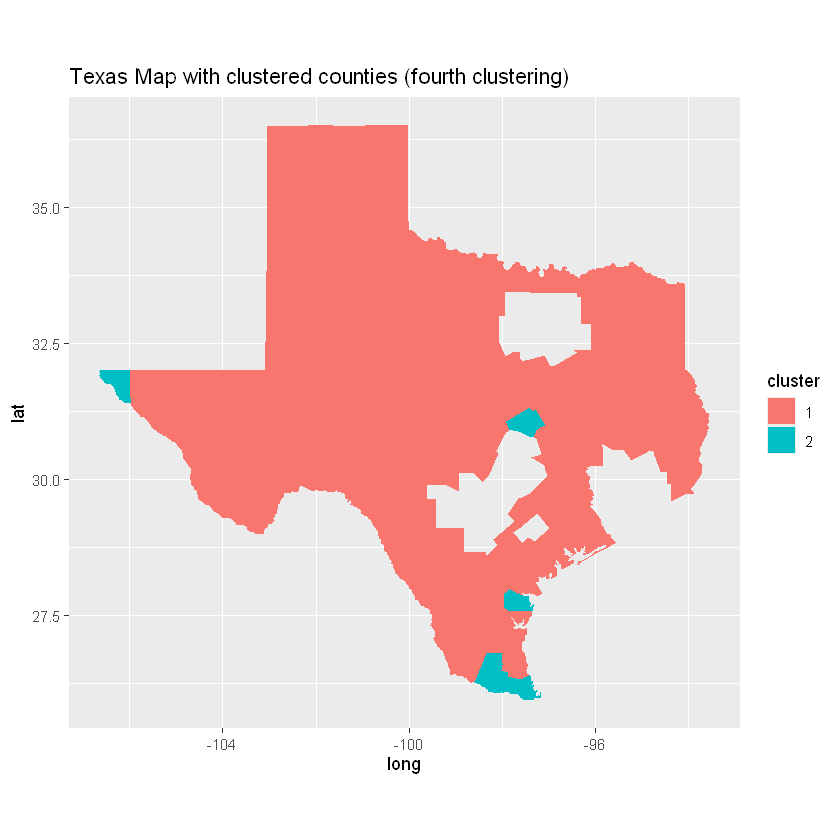

In [821]:
# heat map
ggplot(counties_polygon_TX_clust_fourth, aes(long, lat)) + 
  geom_polygon(aes(group = group, fill = cluster)) +
  coord_quickmap() + 
  labs(title = "Texas Map with clustered counties (fourth clustering)")

# Filter for counties in cluster 2
counties_cluster_2 <- counties_polygon_TX_clust_fourth %>%
  filter(cluster == 2)

# Print the counties in cluster 2
print(unique(counties_cluster_2$county))

In [822]:
dataset_plus_census_fourth_clust_heatmap %>% group_by(cluster) %>% summarize(
  avg_cases_per_1000 = mean(cases_per_1000), 
  avg_deaths_per_1000 = mean(deaths_per_1000))

cluster,avg_cases_per_1000,avg_deaths_per_1000
<fct>,<dbl>,<dbl>
1,82.40390,1.897068
2,78.72391,1.986519


## Compare clusterings (supervised)

In [823]:
dataset_plus_census <- read.csv("https://raw.githubusercontent.com/yamphurai/Project2_ClusterAnalysis/refs/heads/main/updated_COVID-19_cases_plus_census.csv")
dataset_plus_census <- dataset_plus_census %>% filter(state == "TX")

In [824]:
counties_to_exclude <- c(
  "Dallas County", "Tarrant County", "Collin County", "Denton County", "Ellis County",
  "Johnson County", "Kaufman County", "Parker County", "Rockwall County", "Wise County",
  "Hood County", "Travis County", "Williamson County", "Hays County", "Bastrop County",
  "Caldwell County", "Bexar County", "Comal County", "Guadalupe County", "Wilson County",
  "Medina County", "Kendall County", "Bandera County", "Atascosa County", "Harris County",
  "Fort Bend County", "Montgomery County", "Brazoria County", "Galveston County", "Liberty County",
  "Waller County", "Chambers County"
)

# filter the dataset
dataset_plus_census <- dataset_plus_census %>%
  filter(!(county_name %in% counties_to_exclude))

In [825]:
#Checking the ranges for the incomes
summary(dataset_plus_census$median_income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  24794   41537   46412   47428   52295   80938 

In [763]:
# checking to ensure it matches with other datasets used for comparison
length(unique(dataset_plus_census$county_name))

[1] 222

We are good to proceed

In [828]:
# Pick median_income feature as the ground truth

# Convert the median incomes into 3 categories (low is <50K, medium is 51-75K, and high is 76-100K)
dataset_plus_census <- dataset_plus_census %>%
  mutate(income_category = cut(median_income, 
                               breaks = c(0, 50000, 75000, 100000), 
                               labels = c("low", "medium", "high"), 
                               include.lowest = TRUE))

# Extract ground truth labels
ground_truth <- dataset_plus_census$income_category

table(ground_truth)

ground_truth
   low medium   high 
   146     72      4 

This means that about 66% of dataset belong to label "low", 32% to "medium", and about 2% to high.

In [765]:
sum(is.na(dataset_plus_census))

[1] 0

In [766]:
#checking the labels
print(dataset_plus_census$income_category)

  [1] low    low    low    medium low    medium medium low    low    low   
 [11] medium low    low    low    high   medium low    low    medium low   
 [21] medium low    low    low    low    medium medium medium medium low   
 [31] medium medium low    low    medium low    low    medium low    low   
 [41] medium medium low    low    low    low    low    medium low    medium
 [51] low    low    medium medium low    low    medium low    medium low   
 [61] low    low    low    medium low    low    low    low    medium low   
 [71] medium low    medium low    low    medium medium low    medium low   
 [81] medium low    low    low    medium low    medium medium low    low   
 [91] low    low    low    medium low    medium medium low    low    low   
[101] low    medium low    medium low    low    medium low    low    low   
[111] medium low    low    medium low    medium low    low    medium low   
[121] medium medium low    low    low    low    low    medium low    medium
[131] low   

Good to proceed

In [767]:
# Purity function
purity <- function(cluster, truth, show_table = FALSE) {
  if (length(cluster) != length(truth))
    stop("Cluster vector and ground truth vectors are not of the same length!")
  
  tbl <- table(cluster, truth)
  if(show_table)
    print(tbl)
  
  majority <- apply(tbl, 1, max)
  sum(majority) / length(cluster)
}


# Entropy function
entropy <- function(cluster, truth, show_table = FALSE) {
  if (length(cluster) != length(truth))
    stop("Cluster vector and ground truth vectors are not of the same length!")
  
  # calculate membership probability of cluster to class
  tbl <- table(cluster, truth)
  p <- sweep(tbl, 2, colSums(tbl), "/")
  
  if(show_table)
    print(p)

  # calculate cluster entropy
  e <- -p * log(p, 2)
  e <- rowSums(e, na.rm = TRUE)
  
  # weighted sum over clusters
  w <- table(cluster) / length(cluster)
  sum(w * e)
}


In [770]:
# distance for the ground truth
d_groundtruth <- dist(dataset_plus_census)

# Pick the best clustering for each dataset and compare them

# set different values of k for the datasets to compare
k_means_first <- kmeans(dataset_plus_census_scaled_first, centers=2, nstart = 10)
k_means_second <- kmeans(dataset_plus_census_scaled_second, centers=2, nstart = 10)
k_means_third <- kmeans(dataset_plus_census_scaled_third, centers=2, nstart = 10)
k_means_fourth <- kmeans(dataset_plus_census_scaled_fourth, centers=2, nstart = 10)


#compute purity metrics
purity_score_first <- purity(k_means_first$cluster, ground_truth, show_table = TRUE)
purity_score_second <- purity(k_means_second$cluster, ground_truth, show_table = TRUE)
purity_score_third <- purity(k_means_third$cluster, ground_truth, show_table = TRUE)
purity_score_fourth <- purity(k_means_fourth$cluster, ground_truth, show_table = TRUE)

# Comparison
compare_clusterings_with_groundtruth <- rbind(
    truth = c(unlist(fpc::cluster.stats(d_groundtruth, as.numeric(ground_truth), as.numeric(ground_truth), compareonly = TRUE)),
              purity = purity(as.numeric(ground_truth), as.numeric(ground_truth)), 
              entropy = entropy(as.numeric(ground_truth), as.numeric(ground_truth))
              ),
    
    k_means_first = c(unlist(fpc::cluster.stats(d_first, k_means_first$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_first$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_first$cluster, as.numeric(ground_truth))
                ),
  
    k_means_second = c(unlist(fpc::cluster.stats(d_second, k_means_second$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_second$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_second$cluster, as.numeric(ground_truth))
                    ),
    
    k_means_third = c(unlist(fpc::cluster.stats(d_third, k_means_third$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_third$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_third$cluster, as.numeric(ground_truth))
                      ),

    k_means_fourth = c(unlist(fpc::cluster.stats(d_fourth, k_means_fourth$cluster, as.numeric(ground_truth), compareonly = TRUE)),
                     purity = purity(k_means_fourth$cluster, as.numeric(ground_truth)),
                     entropy = entropy(k_means_fourth$cluster, as.numeric(ground_truth)))
    )
     
# Print the comparison results
print(compare_clusterings_with_groundtruth)

Warning message in dist(dataset_plus_census):
"NAs introduced by coercion"


       truth
cluster low medium high
      1 139     69    3
      2   7      3    1
       truth
cluster low medium high
      1   3      2    0
      2 143     70    4
       truth
cluster low medium high
      1   8      3    1
      2 138     69    3
       truth
cluster low medium high
      1   8      2    0
      2 138     70    4
               corrected.rand        vi    purity    entropy
truth             1.000000000 0.0000000 1.0000000 0.00000000
k_means_first     0.010545256 0.9016850 0.6576577 0.46057413
k_means_second    0.002179122 0.8195455 0.6576577 0.07312841
k_means_third     0.006321427 0.9148650 0.6576577 0.47256853
k_means_fourth   -0.018692144 0.8912094 0.6576577 0.12792727


Looking at the first clustering, we can see that about 66% of the datapoints belong to label "low", 32% to "medium", and 1.5% (2% if rounded up) to "high". This distribution is exactly what we have for the ground truth. This tells us that cluster 1 resembles the ground truth distribution closely indicating that the distribution has been performed correctly. Similar observations can be made for the rest of the clusters of each clustering.

The k-means_first clustering has the highest corrected Rand index (0.010545256) among the k-means clusterings, indicating it is the closest to the ground truth. The k-means_second clustering has the lowest VI (0.8195455), indicating it is the closest to the ground truth. All k-means clusterings have the same purity (0.6576577), so this metric does not help distinguish between them. The k-means_second clustering has the lowest entropy (0.07312841), indicating it is the closest to the ground truth. Based on the Variation of Information (VI) and Entropy, the k-means_second clustering appears to be the closest to the ground truth and thus performed the best clustering.

In [1]:
# Convert the notebook to HTML
system(paste("jupyter nbconvert --to html", "Project2_ClusterAnalysis_Group10.ipynb"))

[1] 0